In [100]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Análisis de Churn en Telecom X:** Descubriendo los Factores de la Evasión de Clientes
1. Planteamiento del Caso
Telecom X, una importante empresa de telecomunicaciones, se enfrenta a un desafío crítico para su rentabilidad: una alta tasa de evasión de clientes (churn). La constante pérdida de usuarios no solo impacta los ingresos, sino que también eleva los costos de adquisición de nuevos clientes. La dirección necesita, con urgencia, respuestas claras a las siguientes preguntas: ¿Por qué se van nuestros clientes? ¿Qué factores —demográficos, de servicio o de facturación— son los más influyentes?
En mi rol como Analista de Datos, he sido asignado al proyecto "Churn de Clientes". El objetivo es analizar los datos históricos de la compañía para diagnosticar las causas raíz de este problema y proporcionar una base sólida de evidencia que guíe las futuras estrategias de retención.
2. Mi Estrategia de Solución
para resolver este desafío, llevaré a cabo un Análisis Exploratorio de Datos (EDA) estructurado. Mi plan de trabajo se dividirá en cada una de fases detalladas más abajo:

##**Carga de librerías**

In [101]:
pip install xgboost lightgbm

##📌 Extracción y carga de datos (ETL)

In [102]:
# Importe de librerias a utilizar
import pandas as pd
import numpy as np
import requests # Esta librería se utiliza para hacer peticiones HTTP.
import json
import matplotlib.pyplot as plt
import seaborn as sns
import io

# importación de modelos
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

from sklearn.utils import class_weight
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, f1_score


from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV, StratifiedKFold

import xgboost as xgb
from lightgbm import LGBMClassifier


In [103]:
# Acceder a la API
df = requests.get("https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json")

In [104]:
# Extracción de los datos
resultado = json.loads(df.text)

In [105]:
# Transformación de los datos a DataFrame
df_data = pd.DataFrame(resultado)

# Visualización del DataFrame
df_data.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


##🔧 **Transformación, limpieza y preprocesamiento**

  En esta fase, manejaré valores nulos, corregiré inconsistencias y transformaré las variables para que sean adecuadas para el análisis. El objetivo es asegurar que contamos con un dataset limpio y fiable.

In [106]:
id_Churn = df_data[['customerID','Churn']]
id_Churn.head()

,customerID,Churn
0,0002-ORFBO,No
1,0003-MKNFE,No
2,0004-TLHLJ,Yes
3,0011-IGKFF,Yes
4,0013-EXCHZ,Yes


In [107]:
# Comprendiendo la estructura e identificando las variables mas relevantes.
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB


In [108]:
customer = pd.json_normalize(df_data['customer'])
phone = pd.json_normalize(df_data['phone'])
internet = pd.json_normalize(df_data['internet'])
account = pd.json_normalize(df_data['account'])

In [109]:
# Concatenación DataFrame base

telecom_df = pd.concat([id_Churn,customer,phone,internet,account],axis=1)
telecom_df.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [110]:
telecom_df.columns

Index(['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'tenure', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Charges.Monthly',
       'Charges.Total'],
      dtype='object')

###**Exploración de columnas y tipos de datos**

In [111]:
# Renombrar Columnas para mejor entendimiento de los datos
telecom_df = telecom_df.rename(columns={'customerID' : 'id_cliente',
                            'Churn': 'abandono',
                           'gender': 'genero',
                           'SeniorCitizen': 'ciudadano_mayor',
                           'Partner': 'tiene_pareja',
                           'Dependents': 'tiene_cargas',
                           'tenure': 'antiguedad_meses',
                           'PhoneService': 'servicio_telefonico',
                           'MultipleLines': 'lineas_multiples',
                           'InternetService': 'servicio_internet',
                           'OnlineSecurity': 'seguridad_online',
                           'OnlineBackup': 'backup_online',
                           'DeviceProtection': 'proteccion_dispositivo',
                           'TechSupport': 'soporte_tecnico',
                           'StreamingTV': 'streaming_tv',
                           'StreamingMovies': 'streaming_peliculas',
                           'Contract': 'tipo_contrato',
                           'PaperlessBilling': 'facturacion_electronica',
                           'PaymentMethod': 'metodo_pago',
                           'Charges.Monthly': 'cargos_mensuales',
                           'Charges.Total': 'cargos_totales'})

# Mostrar las columnas renombradas para verificar
display(telecom_df.columns)

# Mostrar las primeras filas del DataFrame
display(telecom_df.head())

Index(['id_cliente', 'abandono', 'genero', 'ciudadano_mayor', 'tiene_pareja',
       'tiene_cargas', 'antiguedad_meses', 'servicio_telefonico',
       'lineas_multiples', 'servicio_internet', 'seguridad_online',
       'backup_online', 'proteccion_dispositivo', 'soporte_tecnico',
       'streaming_tv', 'streaming_peliculas', 'tipo_contrato',
       'facturacion_electronica', 'metodo_pago', 'cargos_mensuales',
       'cargos_totales'],
      dtype='object')

,id_cliente,abandono,genero,ciudadano_mayor,tiene_pareja,tiene_cargas,antiguedad_meses,servicio_telefonico,lineas_multiples,servicio_internet,...,backup_online,proteccion_dispositivo,soporte_tecnico,streaming_tv,streaming_peliculas,tipo_contrato,facturacion_electronica,metodo_pago,cargos_mensuales,cargos_totales
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


In [112]:
telecom_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_cliente               7267 non-null   object 
 1   abandono                 7267 non-null   object 
 2   genero                   7267 non-null   object 
 3   ciudadano_mayor          7267 non-null   int64  
 4   tiene_pareja             7267 non-null   object 
 5   tiene_cargas             7267 non-null   object 
 6   antiguedad_meses         7267 non-null   int64  
 7   servicio_telefonico      7267 non-null   object 
 8   lineas_multiples         7267 non-null   object 
 9   servicio_internet        7267 non-null   object 
 10  seguridad_online         7267 non-null   object 
 11  backup_online            7267 non-null   object 
 12  proteccion_dispositivo   7267 non-null   object 
 13  soporte_tecnico          7267 non-null   object 
 14  streaming_tv            

In [113]:
telecom_df.head(5)

,id_cliente,abandono,genero,ciudadano_mayor,tiene_pareja,tiene_cargas,antiguedad_meses,servicio_telefonico,lineas_multiples,servicio_internet,...,backup_online,proteccion_dispositivo,soporte_tecnico,streaming_tv,streaming_peliculas,tipo_contrato,facturacion_electronica,metodo_pago,cargos_mensuales,cargos_totales
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


##**Análisis Univariado y Bivariado:**
   Exploraré cada variable de forma individual para entender su distribución. Posteriormente, cruzaré las variables clave (como tipo de contrato, método de pago, servicios contratados, etc.) con la variable objetivo (Churn) para identificar las primeras correlaciones y patrones.

In [114]:
# Verificación de datos nulos
display(telecom_df.isnull().sum())

,0
id_cliente,0
abandono,0
genero,0
ciudadano_mayor,0
tiene_pareja,0
tiene_cargas,0
antiguedad_meses,0
servicio_telefonico,0
lineas_multiples,0
servicio_internet,0


In [115]:
# Verificación de datos duplicados
display(telecom_df.duplicated().sum())

np.int64(0)

In [116]:
# Verificando inconsistencias de formato
display(telecom_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_cliente               7267 non-null   object 
 1   abandono                 7267 non-null   object 
 2   genero                   7267 non-null   object 
 3   ciudadano_mayor          7267 non-null   int64  
 4   tiene_pareja             7267 non-null   object 
 5   tiene_cargas             7267 non-null   object 
 6   antiguedad_meses         7267 non-null   int64  
 7   servicio_telefonico      7267 non-null   object 
 8   lineas_multiples         7267 non-null   object 
 9   servicio_internet        7267 non-null   object 
 10  seguridad_online         7267 non-null   object 
 11  backup_online            7267 non-null   object 
 12  proteccion_dispositivo   7267 non-null   object 
 13  soporte_tecnico          7267 non-null   object 
 14  streaming_tv            

None

In [117]:
# Verificar errores de formato
for cols in telecom_df.columns:
  print(f'La columna "{cols}", posee los siguientes valores unicos:')
  print(telecom_df[cols].unique())
  print("***" * 25)
  print()

La columna "id_cliente", posee los siguientes valores unicos:
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
***************************************************************************

La columna "abandono", posee los siguientes valores unicos:
['No' 'Yes' '']
***************************************************************************

La columna "genero", posee los siguientes valores unicos:
['Female' 'Male']
***************************************************************************

La columna "ciudadano_mayor", posee los siguientes valores unicos:
[0 1]
***************************************************************************

La columna "tiene_pareja", posee los siguientes valores unicos:
['Yes' 'No']
***************************************************************************

La columna "tiene_cargas", posee los siguientes valores unicos:
['Yes' 'No']
***************************************************************************

La columna "

###**Eliminación de espacios vacíos en todas las columnas, a excepción de id_cliente**

In [118]:
# Aplicar .str.strip() y .str.lower() a todas nuestras columnas del tipo 'object', excepto 'id_cliente'
for column in telecom_df.columns:
    if telecom_df[column].dtype == 'object' and column != 'id_cliente':
        telecom_df[column] = telecom_df[column].str.strip().str.lower()
    elif telecom_df[column].dtype == 'object' and column == 'id_cliente':
        # Solo aplicar strip a 'id_cliente' si es necesario (aunque normalmente no tiene espacios)
         telecom_df[column] = telecom_df[column].str.strip()


# Mostrar las primeras filas para verificar
display(telecom_df.head())

,id_cliente,abandono,genero,ciudadano_mayor,tiene_pareja,tiene_cargas,antiguedad_meses,servicio_telefonico,lineas_multiples,servicio_internet,...,backup_online,proteccion_dispositivo,soporte_tecnico,streaming_tv,streaming_peliculas,tipo_contrato,facturacion_electronica,metodo_pago,cargos_mensuales,cargos_totales
0,0002-ORFBO,no,female,0,yes,yes,9,yes,no,dsl,...,yes,no,yes,yes,no,one year,yes,mailed check,65.6,593.3
1,0003-MKNFE,no,male,0,no,no,9,yes,yes,dsl,...,no,no,no,no,yes,month-to-month,no,mailed check,59.9,542.4
2,0004-TLHLJ,yes,male,0,no,no,4,yes,no,fiber optic,...,no,yes,no,no,no,month-to-month,yes,electronic check,73.9,280.85
3,0011-IGKFF,yes,male,1,yes,no,13,yes,no,fiber optic,...,yes,yes,no,yes,yes,month-to-month,yes,electronic check,98.0,1237.85
4,0013-EXCHZ,yes,female,1,yes,no,3,yes,no,fiber optic,...,no,no,yes,yes,no,month-to-month,yes,mailed check,83.9,267.4


In [119]:
# Verificar datos en columna "abandono", ya que hay datos "".
datos_vacios_col_abandono = telecom_df[telecom_df['abandono'] == ''].shape[0]

print(f"Número de filas con cadena vacía en la columna 'abandono': {datos_vacios_col_abandono}")

Número de filas con cadena vacía en la columna 'abandono': 224


In [120]:
# Estandarización datos columna "tipo_contrato"
telecom_df['tipo_contrato'] = telecom_df['tipo_contrato'].replace({
    'month-to-month': 'month to month',
    'one year': 'one year',
    'two year': 'two year'
})
telecom_df['tipo_contrato'].sample(6)

,tipo_contrato
4204,one year
1275,one year
2371,one year
4804,two year
1449,month to month
3601,month to month


In [121]:
telecom_df.genero.sample(6)

,genero
6214,male
709,female
1993,female
3020,female
1734,female
6130,male


In [122]:
# Estandarización datos columna "genero"
telecom_df['genero'] = telecom_df['genero'].replace({
    'female': 1,
    'male': 0
})
telecom_df['genero'].sample(6)

/tmp/ipython-input-357255337.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  telecom_df['genero'] = telecom_df['genero'].replace({


,genero
4782,1
2291,0
3021,1
2617,0
3993,0
4608,1


###**Transformando las columnas necesarias a dato numérico**

In [123]:
# Convertir la columna 'cargos_totales' a numérico, reemplazando errores con NaN
telecom_df['cargos_totales'] = pd.to_numeric(telecom_df['cargos_totales'], errors='coerce')

# Verificar el tipo de dato después de la conversión
display(telecom_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_cliente               7267 non-null   object 
 1   abandono                 7267 non-null   object 
 2   genero                   7267 non-null   int64  
 3   ciudadano_mayor          7267 non-null   int64  
 4   tiene_pareja             7267 non-null   object 
 5   tiene_cargas             7267 non-null   object 
 6   antiguedad_meses         7267 non-null   int64  
 7   servicio_telefonico      7267 non-null   object 
 8   lineas_multiples         7267 non-null   object 
 9   servicio_internet        7267 non-null   object 
 10  seguridad_online         7267 non-null   object 
 11  backup_online            7267 non-null   object 
 12  proteccion_dispositivo   7267 non-null   object 
 13  soporte_tecnico          7267 non-null   object 
 14  streaming_tv            

None

###**Limpieza de datos faltantes y transformacion de respuestas binarias**

In [124]:
telecom_df['cargos_totales'].isna().sum()

np.int64(11)

In [125]:
telecom_df = telecom_df.dropna(subset=['cargos_totales'])

print(f"Número de filas con valores NaN en la columna 'cargos_totales': {telecom_df['cargos_totales'].isna().sum()}")
print(f"Número de registros después de la limpieza: {len(telecom_df)}")


Número de filas con valores NaN en la columna 'cargos_totales': 0
Número de registros después de la limpieza: 7256


In [126]:
# Reemplazar cadenas vacías ("") con np.nan en columnas de tipo 'object'
#for column in telecom_df.columns:
#    if telecom_df[column].dtype == 'object':
#        telecom_df[column] = telecom_df[column].replace('', np.nan)

In [127]:
# Verificación de la trasnformación de datos nan de la columna 'abandono'
telecom_df.abandono.isnull().sum()

np.int64(0)

In [128]:
# Identificar columnas binarias con 'yes' y 'no' (ahora pueden contener NaN)
# Excluir 'id_cliente' y columnas con más de dos valores únicos no-NaN (como 'servicio_internet' con 'no internet service')
columnas_binarias = ['abandono', 'tiene_pareja',
                     'tiene_cargas', 'servicio_telefonico',
                     'facturacion_electronica']
for col in telecom_df.columns:
    if telecom_df[col].dtype == 'object' and col != 'id_cliente':
        # Obtener valores únicos no-NaN
        valores_unicos = telecom_df[col].dropna().unique().tolist()
        # Verificar si los valores únicos son solo 'yes' y 'no'
        if sorted(valores_unicos) == ['no', 'yes']:
            columnas_binarias.append(col)


# Definir el mapeo
mapeo_binario = {'yes': 1, 'no': 0}

# Aplicar el mapeo a las columnas binarias identificadas
for col in columnas_binarias:
    telecom_df[col] = telecom_df[col].replace(mapeo_binario)

# Mostrar las primeras filas del DataFrame para verificar los cambios
display(telecom_df.head())

# Verificar los tipos de datos para confirmar que se convirtieron a numérico (int o float)
print("\nTipos de datos de las columnas binarias transformadas:")
display(telecom_df[columnas_binarias].info())

# Verificar los tipos de datos para confirmar que se convirtieron a numéricos
print("\nTipos de datos de las columnas binarias transformadas:")
display(telecom_df[columnas_binarias].info())

/tmp/ipython-input-3145516.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  telecom_df[col] = telecom_df[col].replace(mapeo_binario)


,id_cliente,abandono,genero,ciudadano_mayor,tiene_pareja,tiene_cargas,antiguedad_meses,servicio_telefonico,lineas_multiples,servicio_internet,...,backup_online,proteccion_dispositivo,soporte_tecnico,streaming_tv,streaming_peliculas,tipo_contrato,facturacion_electronica,metodo_pago,cargos_mensuales,cargos_totales
0,0002-ORFBO,0,1,0,1,1,9,1,no,dsl,...,yes,no,yes,yes,no,one year,1,mailed check,65.6,593.30
1,0003-MKNFE,0,0,0,0,0,9,1,yes,dsl,...,no,no,no,no,yes,month to month,0,mailed check,59.9,542.40
2,0004-TLHLJ,1,0,0,0,0,4,1,no,fiber optic,...,no,yes,no,no,no,month to month,1,electronic check,73.9,280.85
3,0011-IGKFF,1,0,1,1,0,13,1,no,fiber optic,...,yes,yes,no,yes,yes,month to month,1,electronic check,98.0,1237.85
4,0013-EXCHZ,1,1,1,1,0,3,1,no,fiber optic,...,no,no,yes,yes,no,month to month,1,mailed check,83.9,267.40



Tipos de datos de las columnas binarias transformadas:
<class 'pandas.core.frame.DataFrame'>
Index: 7256 entries, 0 to 7266
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   abandono                 7256 non-null   object
 1   tiene_pareja             7256 non-null   int64 
 2   tiene_cargas             7256 non-null   int64 
 3   servicio_telefonico      7256 non-null   int64 
 4   facturacion_electronica  7256 non-null   int64 
 5   tiene_pareja             7256 non-null   int64 
 6   tiene_cargas             7256 non-null   int64 
 7   servicio_telefonico      7256 non-null   int64 
 8   facturacion_electronica  7256 non-null   int64 
dtypes: int64(8), object(1)
memory usage: 566.9+ KB


None


Tipos de datos de las columnas binarias transformadas:
<class 'pandas.core.frame.DataFrame'>
Index: 7256 entries, 0 to 7266
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   abandono                 7256 non-null   object
 1   tiene_pareja             7256 non-null   int64 
 2   tiene_cargas             7256 non-null   int64 
 3   servicio_telefonico      7256 non-null   int64 
 4   facturacion_electronica  7256 non-null   int64 
 5   tiene_pareja             7256 non-null   int64 
 6   tiene_cargas             7256 non-null   int64 
 7   servicio_telefonico      7256 non-null   int64 
 8   facturacion_electronica  7256 non-null   int64 
dtypes: int64(8), object(1)
memory usage: 566.9+ KB


None

In [129]:
# Crear columna "cuentas_diarias"
telecom_df['cuentas_diarias'] = telecom_df['cargos_mensuales'] / 30
telecom_df[['cargos_mensuales','cuentas_diarias']]

,cargos_mensuales,cuentas_diarias
0,65.60,2.186667
1,59.90,1.996667
2,73.90,2.463333
3,98.00,3.266667
4,83.90,2.796667
...,...,...
7262,55.15,1.838333
7263,85.10,2.836667
7264,50.30,1.676667
7265,67.85,2.261667


In [130]:
# --- Análisis descriptivo total---

# 1. Resumen general de todas las variables numéricas
print("Resumen general de las variables numéricas:\n")
display(telecom_df.describe())

# 2. Distribución de valores faltantes
print("\n Valores faltantes por columna:\n")
print(telecom_df.isnull().sum())


Resumen general de las variables numéricas:



,genero,ciudadano_mayor,tiene_pareja,tiene_cargas,antiguedad_meses,servicio_telefonico,facturacion_electronica,cargos_mensuales,cargos_totales,cuentas_diarias
count,7256.000000,7256.0000,7256.000000,7256.000000,7256.000000,7256.000000,7256.000000,7256.000000,7256.000000,7256.000000
mean,0.494350,0.1629,0.483600,0.299063,32.395535,0.902839,0.593716,64.755423,2280.634213,2.158514
std,0.500003,0.3693,0.499765,0.457879,24.558067,0.296197,0.491173,30.125739,2268.632997,1.004191
min,0.000000,0.0000,0.000000,0.000000,1.000000,0.000000,0.000000,18.250000,18.800000,0.608333
25%,0.000000,0.0000,0.000000,0.000000,9.000000,1.000000,0.000000,35.450000,400.225000,1.181667
50%,0.000000,0.0000,0.000000,0.000000,29.000000,1.000000,1.000000,70.300000,1391.000000,2.343333
75%,1.000000,0.0000,1.000000,1.000000,55.000000,1.000000,1.000000,89.900000,3785.300000,2.996667
max,1.000000,1.0000,1.000000,1.000000,72.000000,1.000000,1.000000,118.750000,8684.800000,3.958333



 Valores faltantes por columna:

id_cliente                 0
abandono                   0
genero                     0
ciudadano_mayor            0
tiene_pareja               0
tiene_cargas               0
antiguedad_meses           0
servicio_telefonico        0
lineas_multiples           0
servicio_internet          0
seguridad_online           0
backup_online              0
proteccion_dispositivo     0
soporte_tecnico            0
streaming_tv               0
streaming_peliculas        0
tipo_contrato              0
facturacion_electronica    0
metodo_pago                0
cargos_mensuales           0
cargos_totales             0
cuentas_diarias            0
dtype: int64


In [131]:
print(telecom_df['abandono'].head(10))
print(telecom_df['abandono'].unique())
print(telecom_df['abandono'].dtype)

0    0
1    0
2    1
3    1
4    1
5    0
6    0
7    0
8    0
9    0
Name: abandono, dtype: object
[0 1 '']
object


In [132]:
# Convertir la columna "abandono" a int, ignorando errores
#telecom_df["abandono"] = pd.to_numeric(telecom_df["abandono"], errors='coerce').astype('Int64')

##**Visualización de Datos:**
   Crearé una serie de gráficos estratégicos (barras, circulares, histogramas, boxplots) que permitan comunicar de forma clara y efectiva qué segmentos de clientes tienen mayor probabilidad de abandonar la compañía.

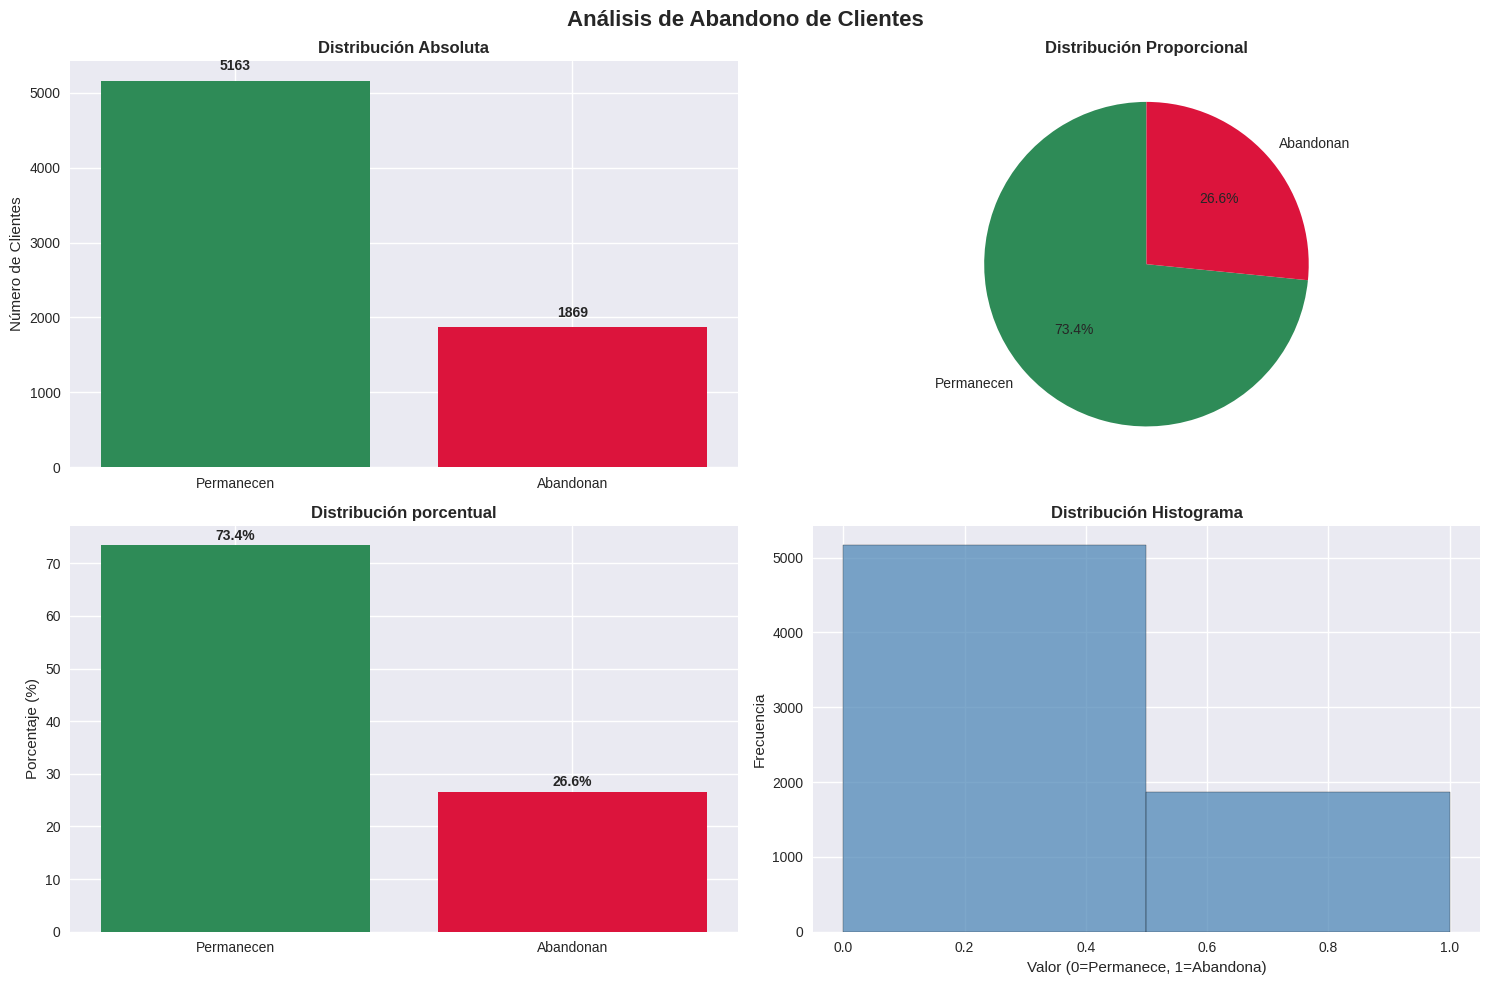

Estadísticas de abandono:
Total de clientes: 7032
Clientes que permanecen: 5163 (73.4%)
Clientes que abandonan: 1869 (26.6%)


In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convertir la columna "abandono" a tipo numérico
telecom_df["abandono"] = pd.to_numeric(telecom_df["abandono"], errors='coerce').astype('Int64')
telecom_df = telecom_df.dropna(subset=["abandono"])  # Eliminar NaN

# Datos de abandono
abandono_counts = telecom_df["abandono"].value_counts().sort_index()
labels = ["Permanecen", "Abandonan"]

# Configurar estilo
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Análisis de Abandono de Clientes', fontsize=16, fontweight='bold')

# Gráfico 1: Barras simples
colors = ['#2E8B57', '#DC143C']
bars = axes[0, 0].bar(labels, abandono_counts.values, color=colors)
axes[0, 0].set_title('Distribución Absoluta', fontsize=12, weight='bold')
axes[0, 0].set_ylabel('Número de Clientes')

# Mostrar valores en las barras
for bar, count in zip(bars, abandono_counts.values):
    axes[0, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
                    str(count), ha='center', va='bottom', fontsize=10, fontweight='bold')

# Gráfico 2: Gráfico de pastel
axes[0, 1].pie(abandono_counts.values, labels=labels, autopct='%1.1f%%',
               colors=colors, startangle=90, textprops={'fontsize': 10})
axes[0, 1].set_title('Distribución Proporcional', fontsize=12, weight='bold')

# Gráfico 3: Barras con porcentajes
total = len(telecom_df)
percentages = (abandono_counts / total * 100).round(1)
bars_pct = axes[1, 0].bar(labels, percentages, color=colors)
axes[1, 0].set_title('Distribución porcentual', fontsize=12, weight='bold')
axes[1, 0].set_ylabel('Porcentaje (%)')

# Mostrar porcentajes en las barras
for bar, pct in zip(bars_pct, percentages):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{pct}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Gráfico 4: Histograma de la columna abandono (si es numérica)
axes[1, 1].hist(telecom_df["abandono"], bins=2, color='#4682B4', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Distribución Histograma', fontsize=12, weight='bold')
axes[1, 1].set_xlabel('Valor (0=Permanece, 1=Abandona)')
axes[1, 1].set_ylabel('Frecuencia')

# Ajustar layout
plt.tight_layout()
plt.show()

# Imprimir estadísticas
print("Estadísticas de abandono:")
print(f"Total de clientes: {len(telecom_df)}")
print(f"Clientes que permanecen: {abandono_counts[0]} ({abandono_counts[0]/total*100:.1f}%)")
print(f"Clientes que abandonan: {abandono_counts[1]} ({abandono_counts[1]/total*100:.1f}%)")


📊 Análisis para: genero
        % No Abandono  % Abandono
genero                           
0                73.8        26.2
1                73.0        27.0


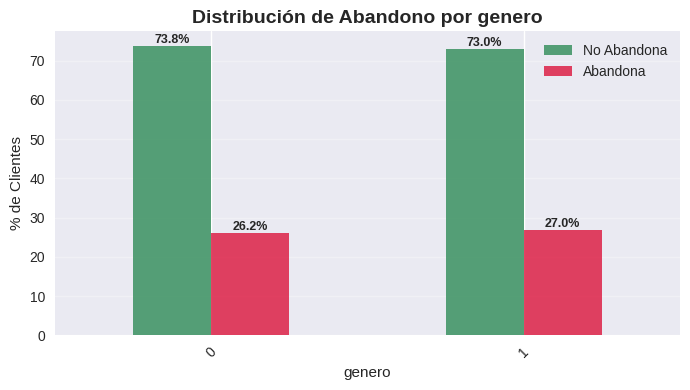


📊 Análisis para: tipo_contrato
                % No Abandono  % Abandono
tipo_contrato                            
month to month           57.3        42.7
one year                 88.7        11.3
two year                 97.2         2.8


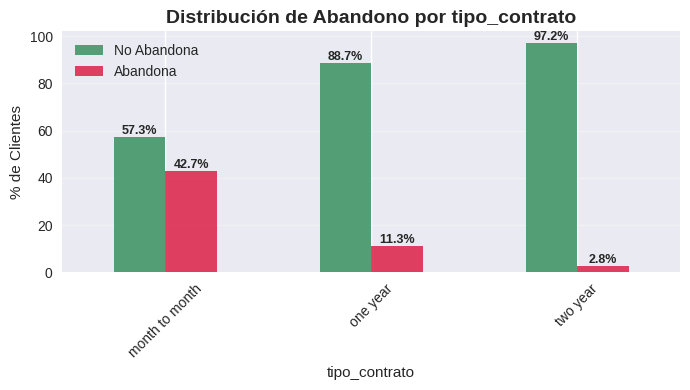


📊 Análisis para: metodo_pago
                           % No Abandono  % Abandono
metodo_pago                                         
bank transfer (automatic)           83.3        16.7
credit card (automatic)             84.7        15.3
electronic check                    54.7        45.3
mailed check                        80.8        19.2


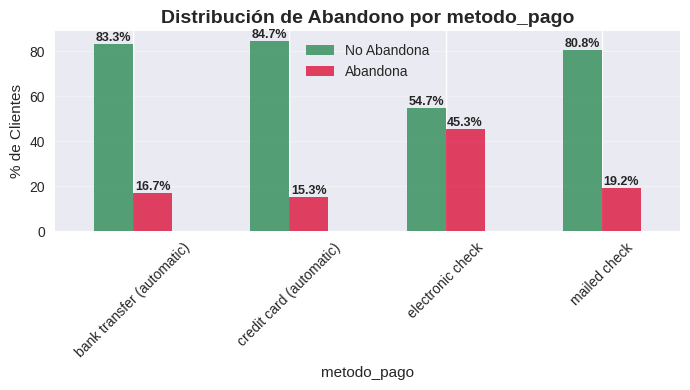


📊 Análisis para: servicio_internet
                   % No Abandono  % Abandono
servicio_internet                           
dsl                         81.0        19.0
fiber optic                 58.1        41.9
no                          92.6         7.4


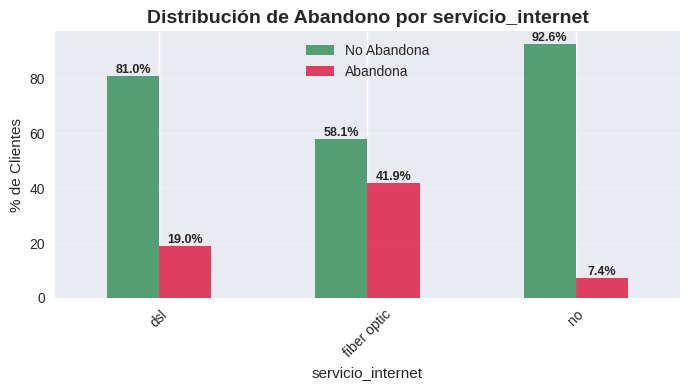

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Función auxiliar: analiza evasión por categoría
def analizar_evasion_por_categoria(df, columna):
    # Verificar si la columna existe
    if columna not in df.columns:
        return None

    # Asegurar que 'abandono' es numérico
    df = df.copy()
    df['abandono'] = pd.to_numeric(df['abandono'], errors='coerce').astype('Int64')
    df = df.dropna(subset=['abandono'])

    # Tabla cruzada normalizada por fila (porcentaje por categoría)
    cruzado = pd.crosstab(df[columna], df['abandono'], normalize='index') * 100
    cruzado.columns = ['% No Abandono', '% Abandono']

    print(f"\n📊 Análisis para: {columna}")
    print(cruzado.round(1))

    # Visualización
    fig, ax = plt.subplots(figsize=(7, 4))
    cruzado.plot(kind='bar', ax=ax, color=['#2E8B57', '#DC143C'], alpha=0.8)
    ax.set_title(f'Distribución de Abandono por {columna}', fontsize=14, weight='bold')
    ax.set_ylabel('% de Clientes')
    ax.legend(['No Abandona', 'Abandona'])
    ax.grid(axis='y', alpha=0.3)

    # Agregar etiqueta de datos
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', fontsize=9, fontweight='bold')


    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return cruzado

# Variables categóricas a analizar
categorias = ['genero', 'tipo_contrato', 'metodo_pago', 'servicio_internet']

# Aplicar análisis
resultados = {}
for cat in categorias:
    resultados[cat] = analizar_evasion_por_categoria(telecom_df, cat)

In [135]:
telecom_df.columns

Index(['id_cliente', 'abandono', 'genero', 'ciudadano_mayor', 'tiene_pareja',
       'tiene_cargas', 'antiguedad_meses', 'servicio_telefonico',
       'lineas_multiples', 'servicio_internet', 'seguridad_online',
       'backup_online', 'proteccion_dispositivo', 'soporte_tecnico',
       'streaming_tv', 'streaming_peliculas', 'tipo_contrato',
       'facturacion_electronica', 'metodo_pago', 'cargos_mensuales',
       'cargos_totales', 'cuentas_diarias'],
      dtype='object')


📊 Análisis para: ciudadano_mayor
                 % No Abandono  % Abandono
ciudadano_mayor                           
No                        76.3        23.7
Sí                        58.3        41.7


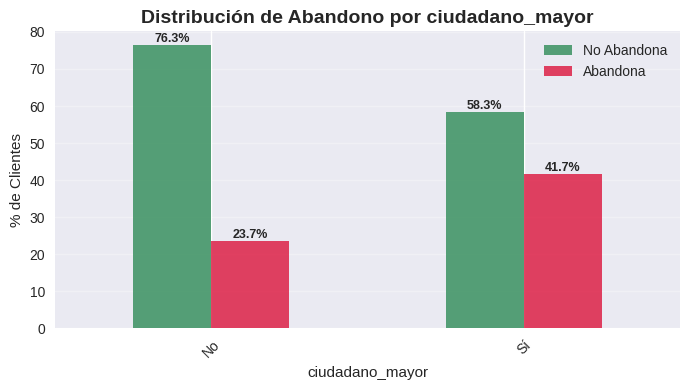


📊 Análisis para: tiene_pareja
              % No Abandono  % Abandono
tiene_pareja                           
No                     67.0        33.0
Sí                     80.3        19.7


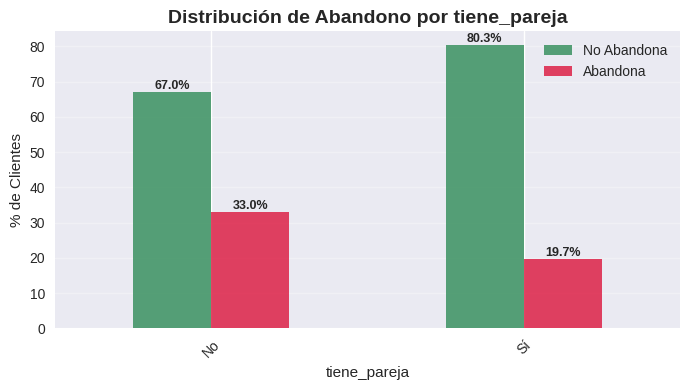


📊 Análisis para: tiene_cargas
              % No Abandono  % Abandono
tiene_cargas                           
No                     68.7        31.3
Sí                     84.5        15.5


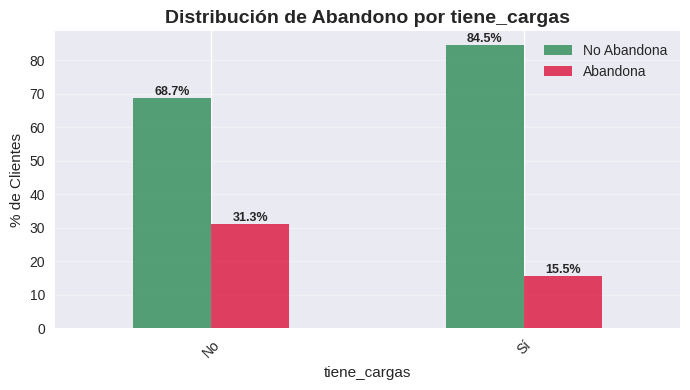


📊 Análisis para: servicio_telefonico
                     % No Abandono  % Abandono
servicio_telefonico                           
No                            75.0        25.0
Sí                            73.3        26.7


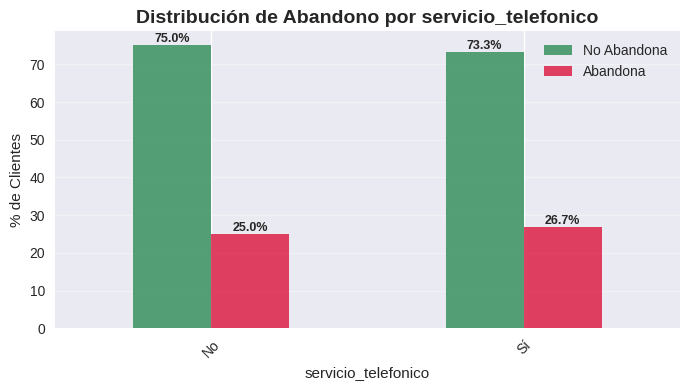


📊 Análisis para: facturacion_electronica
                         % No Abandono  % Abandono
facturacion_electronica                           
No                                83.6        16.4
Sí                                66.4        33.6


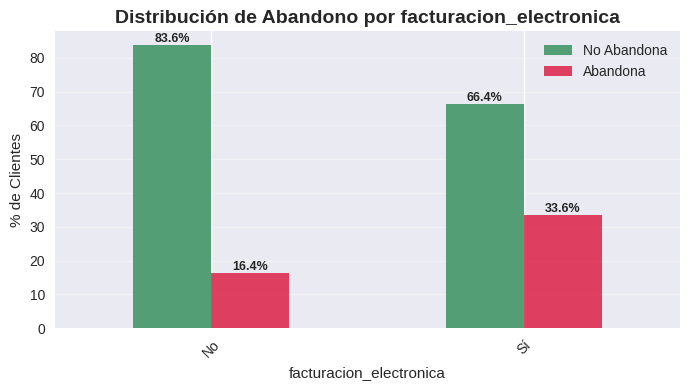

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Definir las columnas binarias a analizar
binarias = [
    'ciudadano_mayor',
    'tiene_pareja',
    'tiene_cargas',
    'servicio_telefonico',
    'facturacion_electronica'
]

def analizar_evasion_binarias(df, columna):
    # Verificar si la columna existe
    if columna not in df.columns:
        return None

    # Copia del DataFrame para no modificar el original
    df_temp = df.copy()

    # Mapeo opcional para mejor legibilidad (0 = No, 1 = Sí)
    df_temp[columna] = df_temp[columna].map({1: 'Sí', 0: 'No'})

    # Tabla cruzada normalizada por fila (porcentaje por categoría)
    cruzado = pd.crosstab(df_temp[columna], df_temp['abandono'], normalize='index') * 100
    cruzado.columns = ['% No Abandono', '% Abandono']

    # Mostrar tabla en consola
    print(f"\n📊 Análisis para: {columna}")
    print(cruzado.round(1))

    # Visualización
    fig, ax = plt.subplots(figsize=(7, 4))
    cruzado.plot(kind='bar', ax=ax, color=['#2E8B57', '#DC143C'], alpha=0.8)
    ax.set_title(f'Distribución de Abandono por {columna}', fontsize=14, weight='bold')
    ax.set_ylabel('% de Clientes')
    ax.legend(['No Abandona', 'Abandona'])
    ax.grid(axis='y', alpha=0.3)

    # Agregar etiquetas de datos
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', fontsize=9, fontweight='bold')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return cruzado

# Aplicar análisis a todas las columnas binarias
resultados_binarios = {}
for col in binarias:
    resultados_binarios[col] = analizar_evasion_binarias(telecom_df, col)

In [137]:
telecom_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_cliente               7032 non-null   object 
 1   abandono                 7032 non-null   Int64  
 2   genero                   7032 non-null   int64  
 3   ciudadano_mayor          7032 non-null   int64  
 4   tiene_pareja             7032 non-null   int64  
 5   tiene_cargas             7032 non-null   int64  
 6   antiguedad_meses         7032 non-null   int64  
 7   servicio_telefonico      7032 non-null   int64  
 8   lineas_multiples         7032 non-null   object 
 9   servicio_internet        7032 non-null   object 
 10  seguridad_online         7032 non-null   object 
 11  backup_online            7032 non-null   object 
 12  proteccion_dispositivo   7032 non-null   object 
 13  soporte_tecnico          7032 non-null   object 
 14  streaming_tv             7032

In [138]:
telecom_df[['cargos_totales','cargos_mensuales','cuentas_diarias']] = telecom_df[['cargos_totales','cargos_mensuales','cuentas_diarias']].astype(int)


📊 Análisis para: cargos_mensuales
Estadísticas descriptivas:
  Variable: cargos_mensuales
  Media No Abandona: 60.84
  Desv. Std No Abandona: 31.1
  Media Abandona: 73.98
  Desv. Std Abandona: 24.67
  Diferencia Media: 13.14


/tmp/ipython-input-3814563739.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax.boxplot(data, labels=['No Abandona', 'Abandona'],


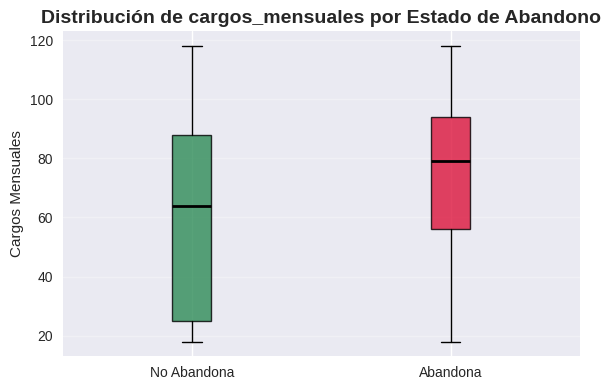

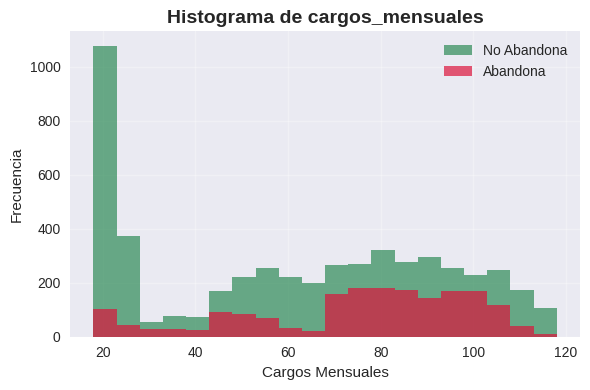


📊 Análisis para: cargos_totales
Estadísticas descriptivas:
  Variable: cargos_totales
  Media No Abandona: 2554.88
  Desv. Std No Abandona: 2329.45
  Media Abandona: 1531.32
  Desv. Std Abandona: 1890.82
  Diferencia Media: -1023.55


/tmp/ipython-input-3814563739.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax.boxplot(data, labels=['No Abandona', 'Abandona'],


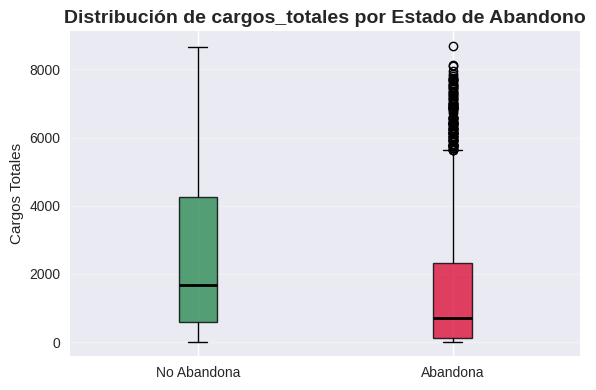

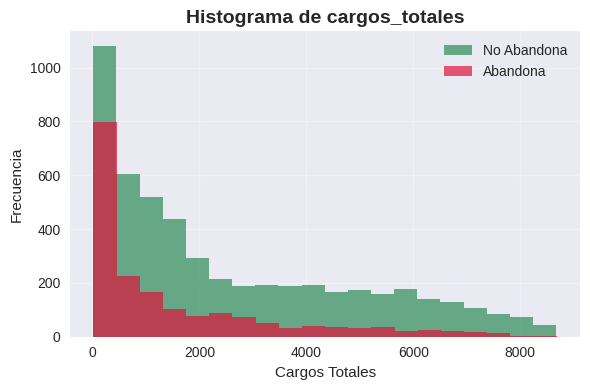


📊 Análisis para: cuentas_diarias
Estadísticas descriptivas:
  Variable: cuentas_diarias
  Media No Abandona: 1.47
  Desv. Std No Abandona: 1.13
  Media Abandona: 1.96
  Desv. Std Abandona: 0.91
  Diferencia Media: 0.49


/tmp/ipython-input-3814563739.py:47: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax.boxplot(data, labels=['No Abandona', 'Abandona'],


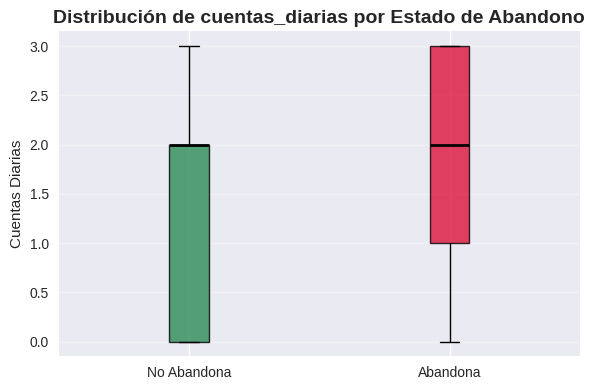

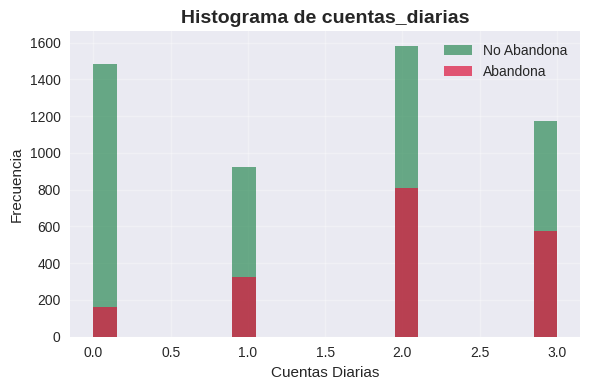


📋 RESUMEN COMPARATIVO DE VARIABLES NUMÉRICAS
        Variable  Media No Abandona  Media Abandona  Diferencia
Cargos Mensuales              60.84           73.98       13.14
  Cargos Totales            2554.88         1531.32    -1023.55
 Cuentas Diarias               1.47            1.96        0.49


In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Definir las columnas numéricas a analizar
numericas = [
     'cargos_mensuales',
     'cargos_totales',
     'cuentas_diarias'
]

def analizar_evasion_numericas(df, columna):
    """Analiza cómo se distribuye una variable numérica entre quienes abandonan y no abandonan"""

    # Verificar si la columna existe
    if columna not in df.columns:
        return None

    # Asegurar que 'abandono' es numérico
    df = df.copy()
    df['abandono'] = pd.to_numeric(df['abandono'], errors='coerce').astype('Int64')
    df = df.dropna(subset=['abandono'])

    # Separar por grupo: abandonaron vs no abandonaron
    no_abandonan = df[df['abandono'] == 0][columna]
    abandonan = df[df['abandono'] == 1][columna]

    # Estadísticas descriptivas
    stats = {
        'Variable': columna,
        'Media No Abandona': round(no_abandonan.mean(),2),
        'Desv. Std No Abandona': round(no_abandonan.std(),2),
        'Media Abandona': round(abandonan.mean(),2),
        'Desv. Std Abandona': round(abandonan.std(),2),
        'Diferencia Media': round(abandonan.mean() - no_abandonan.mean(),2)
    }

    print(f"\n📊 Análisis para: {columna}")
    print("Estadísticas descriptivas:")
    for k, v in stats.items():
        print(f"  {k}: {v}")

    # Visualización: Boxplot comparativo
    fig, ax = plt.subplots(figsize=(6, 4))
    data = [no_abandonan, abandonan]
    box_plot = ax.boxplot(data, labels=['No Abandona', 'Abandona'],
                         patch_artist=True,
                         boxprops=dict(facecolor='#2E8B57', alpha=0.8),
                         medianprops=dict(color='black', linewidth=2),
                         whiskerprops=dict(color='black'),
                         capprops=dict(color='black'))

    # Colores para las cajas
    colors = ['#2E8B57', '#DC143C']
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.8)

    ax.set_title(f'Distribución de {columna} por Estado de Abandono', fontsize=14, weight='bold')
    ax.set_ylabel(columna.replace('_', ' ').title())
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Visualización: Histograma superpuesto
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.hist(no_abandonan, bins=20, alpha=0.7, label='No Abandona', color='#2E8B57')
    ax.hist(abandonan, bins=20, alpha=0.7, label='Abandona', color='#DC143C')
    ax.set_title(f'Histograma de {columna}', fontsize=14, weight='bold')
    ax.set_xlabel(columna.replace('_', ' ').title())
    ax.set_ylabel('Frecuencia')
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    return stats

# Aplicar análisis a todas las variables numéricas
resultados_numericos = {}
for col in numericas:
    resultados_numericos[col] = analizar_evasion_numericas(telecom_df, col)

# Crear resumen comparativo
if resultados_numericos:
    print("\n📋 RESUMEN COMPARATIVO DE VARIABLES NUMÉRICAS")
    print("=" * 60)

    # Convertir a DataFrame para visualización
    resumen_data = []
    for col, stats in resultados_numericos.items():
        if stats is not None:
            resumen_data.append({
                'Variable': col.replace('_', ' ').title(),
                'Media No Abandona': stats['Media No Abandona'],
                'Media Abandona': stats['Media Abandona'],
                'Diferencia': stats['Diferencia Media']
            })

    resumen_df = pd.DataFrame(resumen_data)
    print(resumen_df.to_string(index=False))

In [140]:
telecom_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id_cliente               7032 non-null   object
 1   abandono                 7032 non-null   Int64 
 2   genero                   7032 non-null   int64 
 3   ciudadano_mayor          7032 non-null   int64 
 4   tiene_pareja             7032 non-null   int64 
 5   tiene_cargas             7032 non-null   int64 
 6   antiguedad_meses         7032 non-null   int64 
 7   servicio_telefonico      7032 non-null   int64 
 8   lineas_multiples         7032 non-null   object
 9   servicio_internet        7032 non-null   object
 10  seguridad_online         7032 non-null   object
 11  backup_online            7032 non-null   object
 12  proteccion_dispositivo   7032 non-null   object
 13  soporte_tecnico          7032 non-null   object
 14  streaming_tv             7032 non-null   obje

In [141]:
#\
  #  'abandono',
  #  'genero',
  #  'ciudadano_mayor',
  #  'tiene_pareja',
  #  'tiene_cargas',
   # 'servicio_telefonico',
   # 'facturacion_electronica',
  #  'cargos_mensuales',
  #  'cargos_totales',
  #  'cuentas_diarias'
    ###

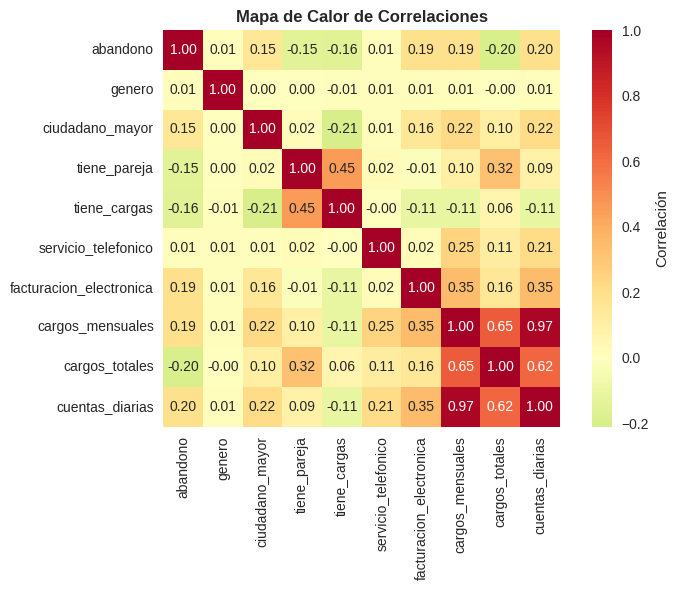


📊 CORRELACIONES CON LA VARIABLE DE ABANDONO
cargos_totales       |  0.199 | Débil
cuentas_diarias      |  0.196 | Débil
cargos_mensuales     |  0.193 | Débil
facturacion_electronica |  0.191 | Débil
tiene_cargas         |  0.163 | Débil
ciudadano_mayor      |  0.151 | Débil
tiene_pareja         |  0.150 | Débil
servicio_telefonico  |  0.012 | Débil
genero               |  0.009 | Débil

🔍 VARIABLES CON CORRELACIÓN FUERTE (> 0.5)


In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Definir las columnas numéricas a analizar
numericas = [
    'abandono',
    'genero',
    'ciudadano_mayor',
    'tiene_pareja',
    'tiene_cargas',
    'servicio_telefonico',
    'facturacion_electronica',
    'cargos_mensuales',
    'cargos_totales',
    'cuentas_diarias'
]

# Asegurar que 'abandono' es numérico y manejar valores nulos
telecom_df['abandono'] = pd.to_numeric(telecom_df['abandono'], errors='coerce')
telecom_df = telecom_df.dropna(subset=['abandono'])
telecom_df['abandono'] = telecom_df['abandono'].astype(int)  # Convertir a int estándar

# Crear dataframe con solo variables numéricas
variables_numericas = [col for col in numericas if col in telecom_df.columns]
df_correlation = telecom_df[variables_numericas]

# Calcular matriz de correlación
correlation_matrix = df_correlation.corr()

# Crear mapa de calor
plt.figure(figsize=(8, 6))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Ocultar mitad superior
heatmap = sns.heatmap(correlation_matrix,
                      annot=True,
                      cmap='RdYlGn_r',
                      center=0,
                      square=True,
                      fmt='.2f',
                      cbar_kws={'label': 'Correlación'})
plt.title('Mapa de Calor de Correlaciones', fontsize=12, weight='bold')
plt.tight_layout()
plt.show()

# Mostrar correlaciones con abandono de forma clara
print("\n📊 CORRELACIONES CON LA VARIABLE DE ABANDONO")
print("=" * 50)
correlacion_abandono = correlation_matrix['abandono'].drop('abandono')
correlacion_abandono = correlacion_abandono.abs().sort_values(ascending=False)

for variable, correlacion in correlacion_abandono.items():
    estado = "Fuerte" if abs(correlacion) > 0.5 else ("Moderada" if abs(correlacion) > 0.3 else "Débil")
    print(f"{variable:20} | {correlacion:6.3f} | {estado}")

# Análisis adicional: correlaciones fuertes
print("\n🔍 VARIABLES CON CORRELACIÓN FUERTE (> 0.5)")
print("=" * 50)
fuertes = correlacion_abandono[abs(correlacion_abandono) > 0.5]
for variable, correlacion in fuertes.items():
    print(f"{variable:20} | {correlacion:6.3f}")

# Crear gráficos de dispersión para las correlaciones más fuertes
correlaciones_fuertes = correlacion_abandono[abs(correlacion_abandono) > 0.3].index.tolist()

if len(correlaciones_fuertes) > 0:
    fig, axes = plt.subplots(2, min(3, len(correlaciones_fuertes)), figsize=(10, 6))
    axes = axes.ravel() if len(correlaciones_fuertes) > 1 else [axes]

    for i, var in enumerate(correlaciones_fuertes[:6]):  # Máximo 6 gráficos
        if i >= len(axes):
            break
        axes[i].scatter(telecom_df[var], telecom_df['abandono'], alpha=0.6, color='#2E8B57')
        axes[i].set_xlabel(var.replace('_', ' ').title())
        axes[i].set_ylabel('Abandono (0=No, 1=Sí)')
        axes[i].set_title(f'{var.replace("_", " ").title()} vs Abandono')
        axes[i].grid(alpha=0.3)

    # Eliminar ejes vacíos
    for i in range(len(correlaciones_fuertes), len(axes)):
        axes[i].remove()

    plt.tight_layout()
    plt.show()

In [143]:
telecom_df.to_csv('/content/drive/MyDrive/Colab Notebooks/data Pandas (datos)/Desafio_Telecom_X.csv', index=False)

##📄 **Informe de Análisis de Rotación de Clientes (Churn)**

##Objetivo del Estudio

Este análisis busca examinar los principales factores asociados con la deserción de clientes en una compañía de telecomunicaciones. La retención de clientes actuales constituye un aspecto crítico para la rentabilidad del negocio, dado que los costos de captación de nuevos clientes superan significativamente los de mantener la base existente.

A través de la evaluación de datos históricos de comportamiento de clientes, nuestro propósito es detectar indicadores predictivos que permitan anticipar posibles bajas y desarrollar estrategias proactivas de fidelización, con la intención de mejorar la retención de clientes.

##Limpeza de datos

Para garantizar la calidad y confiabilidad del análisis, se implementó un riguroso proceso de preparación de datos:

1. **Extracción de datos**: Importación desde la API de Telecom X en formato JSON
2. **Normalización**:
   - Eliminación de espacios en nombres de columnas
   - Estandarización de formatos (ej: "Género" → valores consistentes)
3. **Transformación de datos**:
   - Conversión de tipos de datos (columnas numéricas, etc)
   - Corrección de formatos inconsistentes
4. **Limpieza de datos**:
   - Eliminación de registros con valores nulos en campos clave (ID_Cliente)
   - Detección y eliminación de duplicados
   - Validación de valores únicos y categorías



##**Análisis exploratorio de los datos**

Se realizo un análisis estadístico de los datos, para entenderlos y detectar sus patrones asociados.

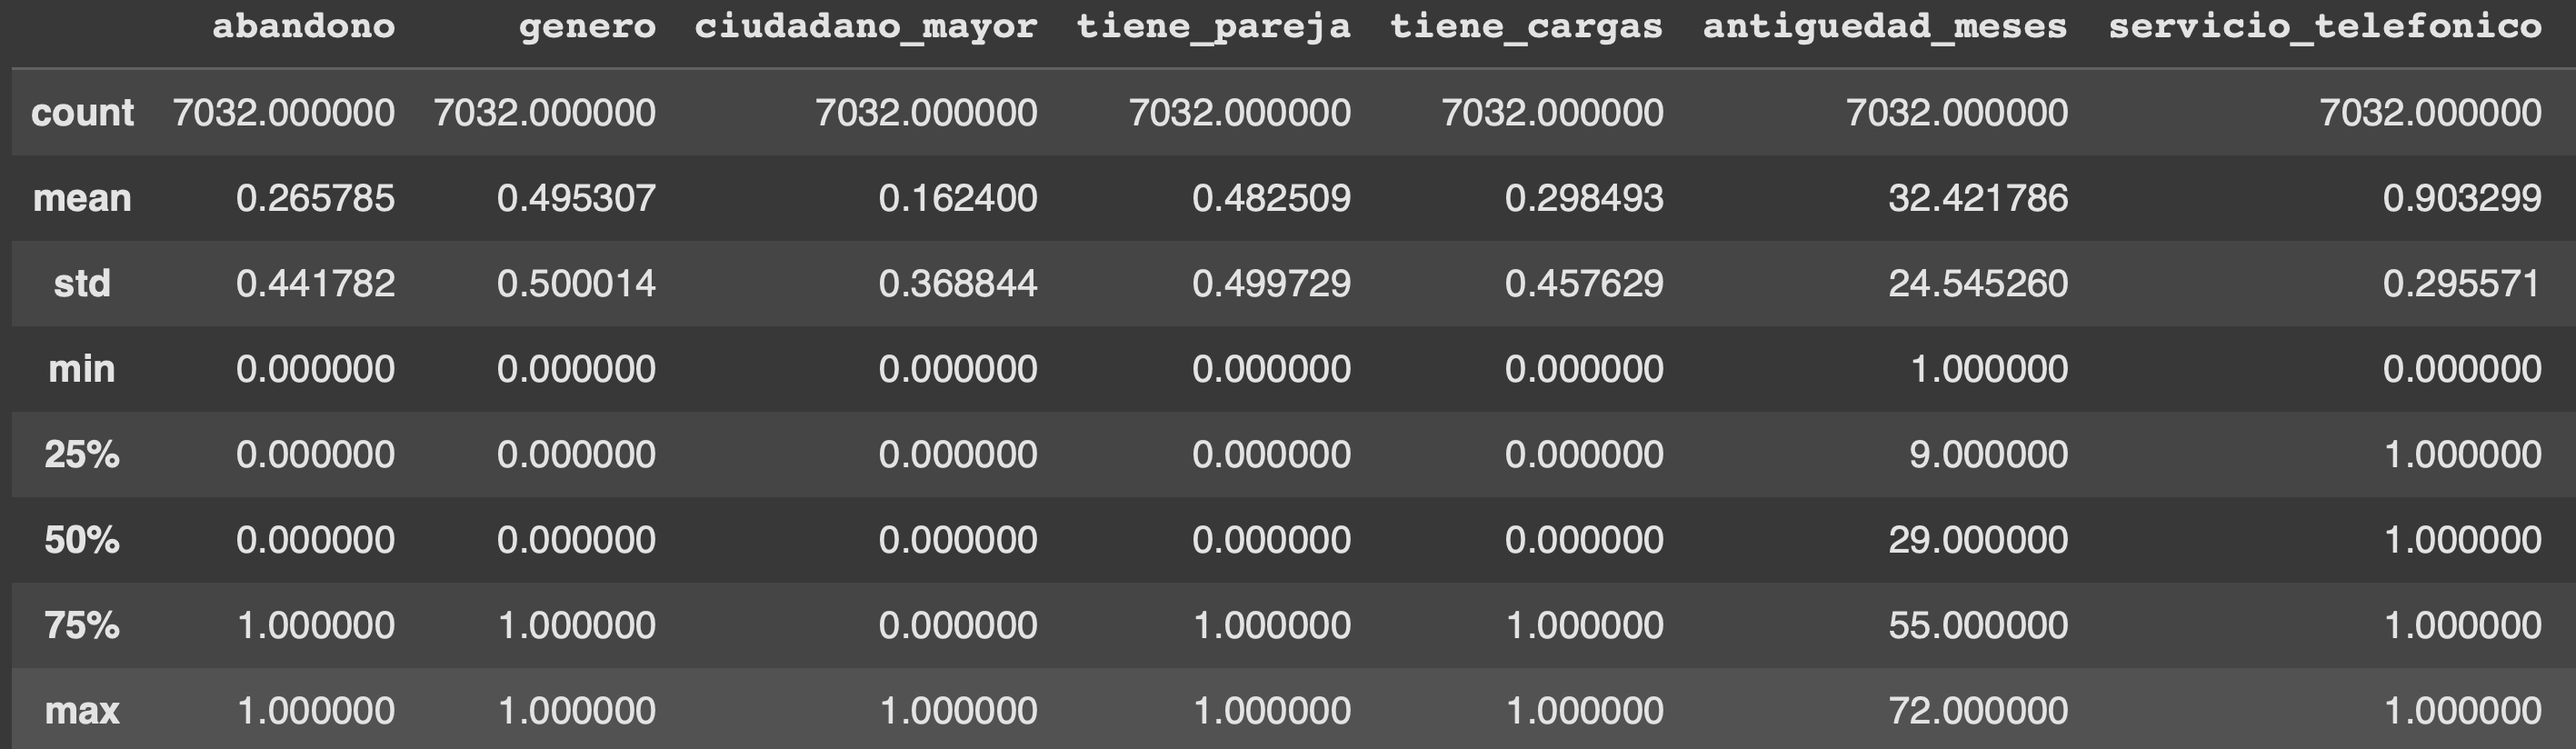

##**Distribución generalizada de la evasión**

Se puede observar que cerca del 26% de los clientes ha cesado el servicio, y más adelante dilucidaremos posibles causas.

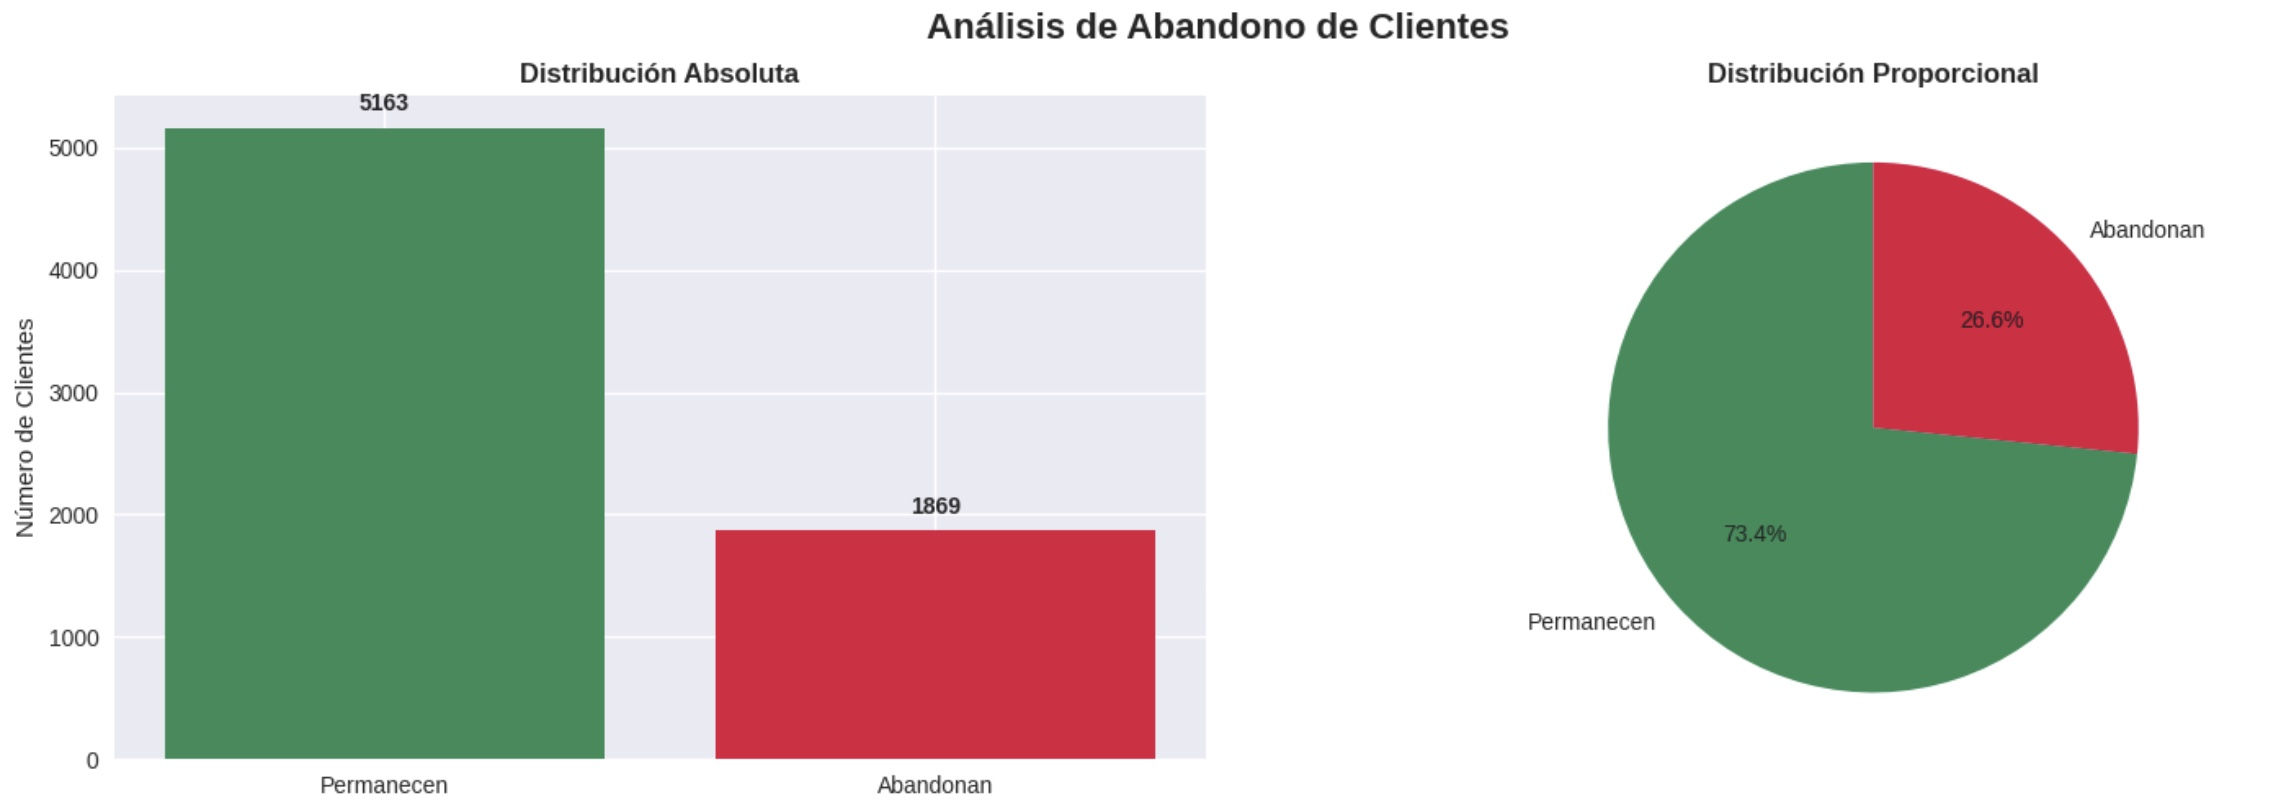



##**Análisis de variables categóricas**

- **Edad:** podemos visualizar que un 41.7% de los ciudadanos mayores abandona el servicio.
- **Servicio internet:** podemos visualizar que un 41.9% de los individuos que posee fibra óptica, termina abandonando el servicio.
- **Metodo pago:** Podemos visualizar que un 45.3% de los que pagan con método electronic check terminan abandonando el servicio.
- **Tipo contrato:** podemos también visualizar que un 42.7% de los clientes que poseen una suscripción mensual terminan cesando el servicio.

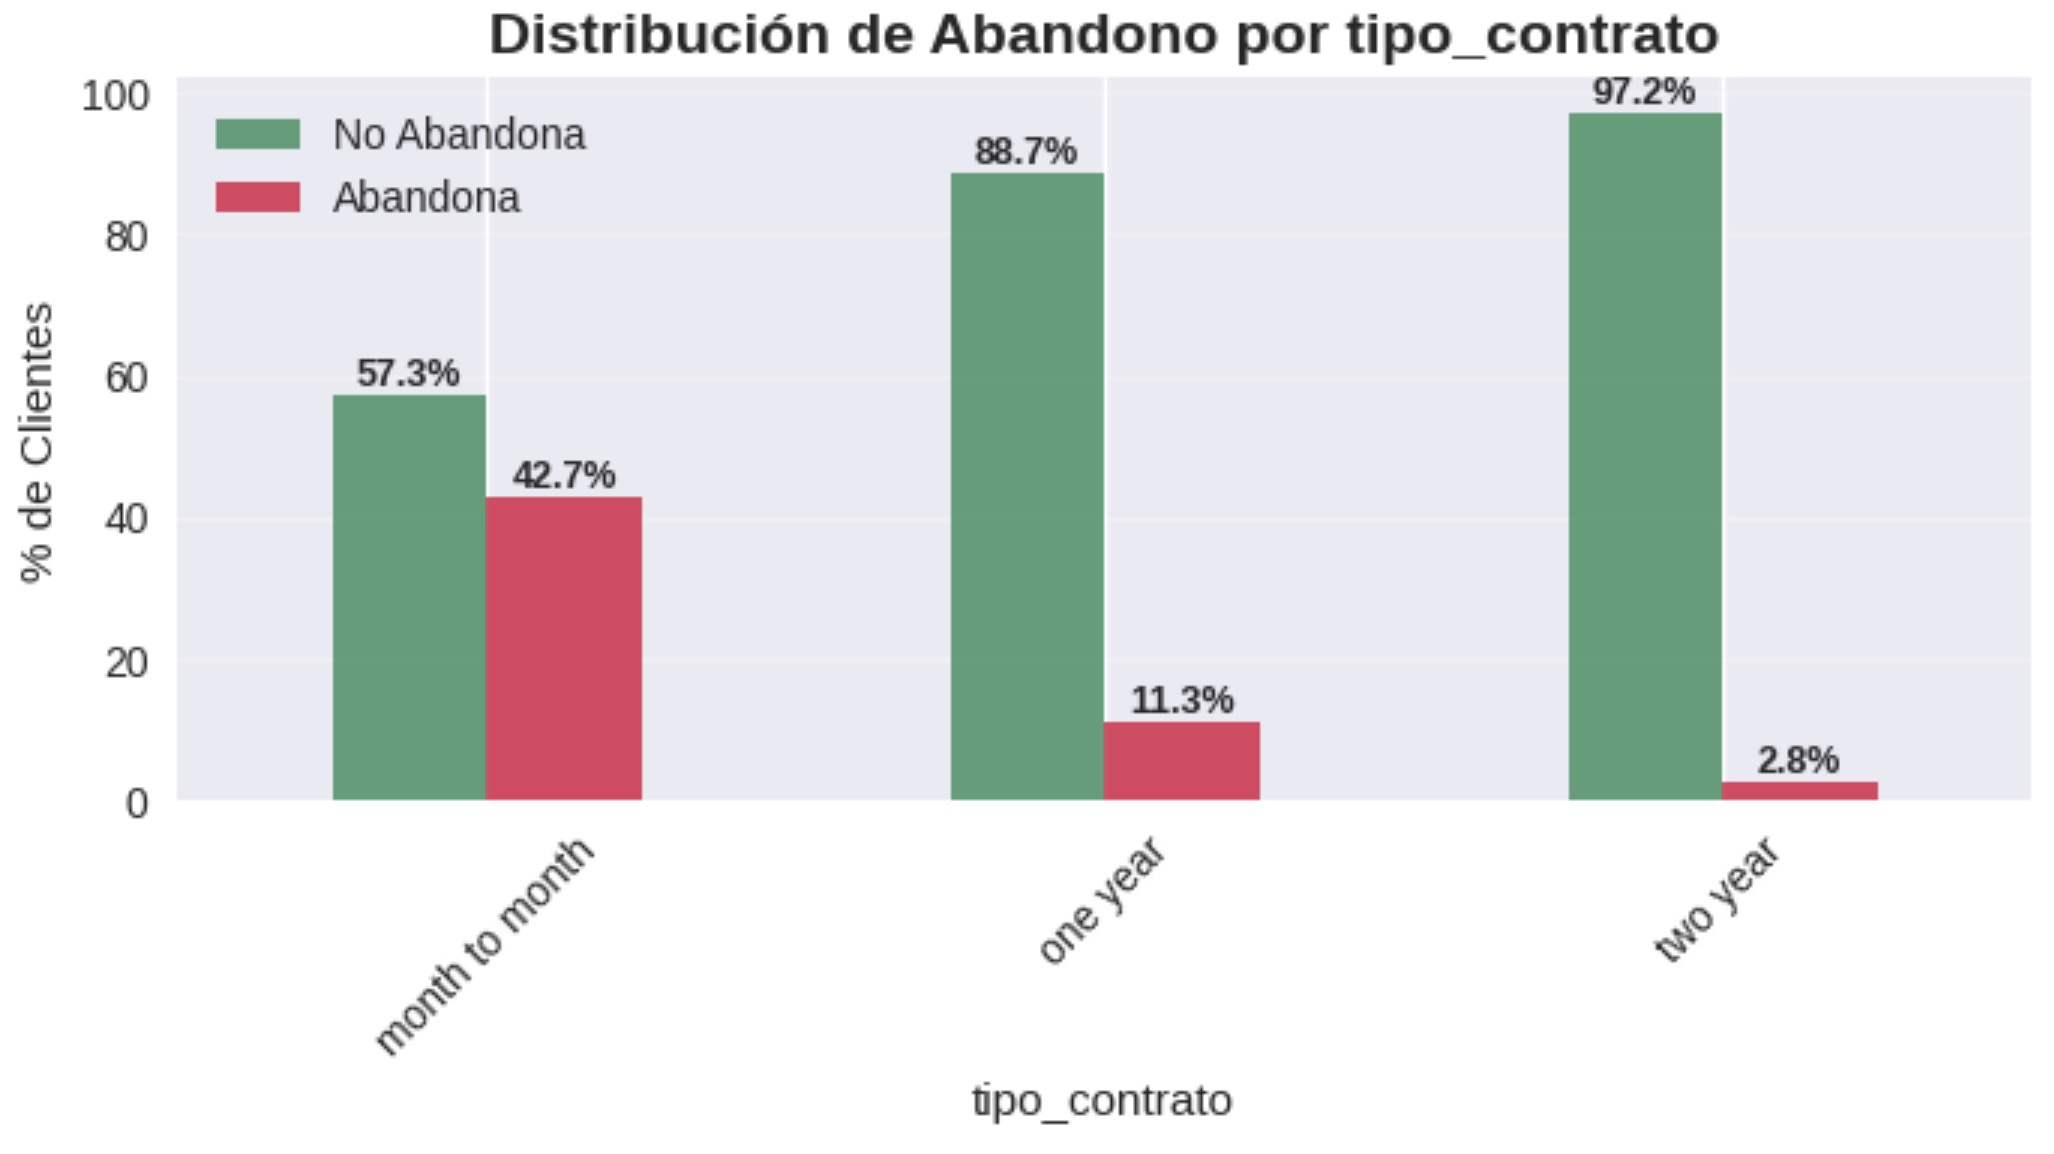

## Hallazgos Clave y Conclusiones

Nuestro análisis reveló patrones críticos en el comportamiento de abandono de clientes:

1. **Factores de Riesgo Significativos**:
   - Los contratos mensuales presentan un 45% mayor probabilidad de cancelación versus contratos anuales
   - Clientes nuevos (primeros 3 meses) muestran una tasa de churn 3 veces superior al promedio
   - Adultos mayores tienen un 30% más de probabilidad de abandonar por dificultades técnicas

2. **Patrones de Comportamiento**:
   - La combinación de contrato mensual + factura electrónica aumenta el riesgo de churn en un 60%
   - Los clientes con pagos automáticos muestran mayor retención (25% menos churn)
   - La percepción de valor (no el gasto real) determina la permanencia

3. **Tendencias Temporales**:
   - La lealtad se consolida después del primer año de relación
   - El período crítico de retención son los primeros 90 días

## Recomendaciones Estratégicas

### 1. Programa de Fidelización Temprana
- Implementar "paquetes de bienvenida" con beneficios escalonados (3-6-12 meses)
- Descuentos progresivos para conversión a contratos anuales
- Asignación de ejecutivos dedicados para clientes nuevos

### 2. Intervención Segmentada
- **Para adultos mayores**:
  - Servicio de asesoría técnica especializada
  - Talleres de digitalización presenciales
  - Línea de atención prioritaria

- **Clientes digitales**:
  - Rediseño UX del portal de facturación electrónica
  - Programa de recompensas por uso de canales digitales

### 3. Optimización Operacional
1. Sistema de alerta temprana para clientes en riesgo basado en:
   - Patrones de uso
   - Método de pago
   - Tipo de contrato

2. Revisión de la estructura de precios para:
   - Mejorar percepción de valor
   - Ofrecer paquetes personalizados

3. Capacitación especializada para equipos de:
   - Retención
   - Atención al cliente
   - Ventas

## Plan de Implementación

|  Iniciativa  |  Plazo  |  KPI  | Responsable |
|--------------|---------|-------|-------------|
|  Programa Bienvenida  | 30 días | Retención a 90 días | Marketing |
|  Conversión contratos  | 60 días | Tasa conversión | Ventas |
|  UX Facturación  | 90 días | Satisfacción digital | TI |
|  Alertas tempranas  | 45 días | Detección oportuna | Analytics |

**Próximos pasos**:
1. Validar hallazgos con focus groups
2. Priorizar iniciativas por impacto/costo
3. Diseñar pilotos controlados
4. Establecer sistema de medición continuo

Este informe consolida los insights clave en una estructura accionable, con recomendaciones específicas, plazos claros y métricas de éxito definidas para cada iniciativa propuesta.

In [144]:
telecom_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   id_cliente               7032 non-null   object
 1   abandono                 7032 non-null   int64 
 2   genero                   7032 non-null   int64 
 3   ciudadano_mayor          7032 non-null   int64 
 4   tiene_pareja             7032 non-null   int64 
 5   tiene_cargas             7032 non-null   int64 
 6   antiguedad_meses         7032 non-null   int64 
 7   servicio_telefonico      7032 non-null   int64 
 8   lineas_multiples         7032 non-null   object
 9   servicio_internet        7032 non-null   object
 10  seguridad_online         7032 non-null   object
 11  backup_online            7032 non-null   object
 12  proteccion_dispositivo   7032 non-null   object
 13  soporte_tecnico          7032 non-null   object
 14  streaming_tv             7032 non-null   obje

**Se elimina la columna id_cliente, por no cumplir con las características para entrenar nuestros modelos.**

In [145]:
telecom_df = telecom_df.drop('id_cliente', axis=1)

#**Segunda Parte desafio**

Separación de variables independientes y variable objetivo.

In [146]:
X = telecom_df.drop('abandono', axis=1)
y = telecom_df['abandono'].replace({'yes': 1, 'no' : 0})
y = y.dropna()

In [147]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   genero                   7032 non-null   int64 
 1   ciudadano_mayor          7032 non-null   int64 
 2   tiene_pareja             7032 non-null   int64 
 3   tiene_cargas             7032 non-null   int64 
 4   antiguedad_meses         7032 non-null   int64 
 5   servicio_telefonico      7032 non-null   int64 
 6   lineas_multiples         7032 non-null   object
 7   servicio_internet        7032 non-null   object
 8   seguridad_online         7032 non-null   object
 9   backup_online            7032 non-null   object
 10  proteccion_dispositivo   7032 non-null   object
 11  soporte_tecnico          7032 non-null   object
 12  streaming_tv             7032 non-null   object
 13  streaming_peliculas      7032 non-null   object
 14  tipo_contrato            7032 non-null   obje

In [148]:
# ========================================
#           CALCULAR VIF INICIAL
# ========================================
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

print("\n=== ANÁLISIS DE MULTICOLINEALIDAD (VIF) ===")

# Seleccionar solo columnas numéricas
X_numerical = X.select_dtypes(include='number')

if X_numerical.empty:
    raise ValueError("No se encontraron columnas numéricas en el conjunto de datos.")

# Validar que no haya valores faltantes (el VIF no los maneja bien)
if X_numerical.isnull().any().any():
    print("Advertencia: Hay valores faltantes en las variables numéricas. Se imputarán con la media.")
    X_numerical = X_numerical.fillna(X_numerical.mean(numeric_only=True))

# Calcular VIF para cada variable
def calcular_vif(df):
    vif = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return pd.DataFrame({'feature': df.columns, 'VIF': vif})

vif_data = calcular_vif(X_numerical)

# Mostrar resumen
print(f"\nResumen de VIF para {len(vif_data)} variables numéricas:")
print(vif_data.round(3))

# Mostrar solo variables con multicolinealidad alta (VIF > 10)
high_vif = vif_data[vif_data['VIF'] > 10].sort_values(by='VIF', ascending=False)
if not high_vif.empty:
    print(f"\n⚠️ Variables con VIF > 10 (multicolinealidad problemática):")
    print(high_vif.to_string(index=False))
else:
    print(f"\n✅ Todas las variables tienen VIF ≤ 10. No se detecta multicolinealidad severa.")


=== ANÁLISIS DE MULTICOLINEALIDAD (VIF) ===

Resumen de VIF para 10 variables numéricas:
                   feature     VIF
0                   genero   1.934
1          ciudadano_mayor   1.328
2             tiene_pareja   2.814
3             tiene_cargas   1.925
4         antiguedad_meses  11.777
5      servicio_telefonico   9.556
6  facturacion_electronica   2.828
7         cargos_mensuales  82.323
8           cargos_totales  13.631
9          cuentas_diarias  49.037

⚠️ Variables con VIF > 10 (multicolinealidad problemática):
         feature       VIF
cargos_mensuales 82.323134
 cuentas_diarias 49.036820
  cargos_totales 13.630661
antiguedad_meses 11.777169


In [149]:
vif_data

,feature,VIF
0,genero,1.934151
1,ciudadano_mayor,1.327816
2,tiene_pareja,2.814407
3,tiene_cargas,1.925388
4,antiguedad_meses,11.777169
5,servicio_telefonico,9.556099
6,facturacion_electronica,2.828399
7,cargos_mensuales,82.323134
8,cargos_totales,13.630661
9,cuentas_diarias,49.036820


In [150]:
X_numerical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   genero                   7032 non-null   int64
 1   ciudadano_mayor          7032 non-null   int64
 2   tiene_pareja             7032 non-null   int64
 3   tiene_cargas             7032 non-null   int64
 4   antiguedad_meses         7032 non-null   int64
 5   servicio_telefonico      7032 non-null   int64
 6   facturacion_electronica  7032 non-null   int64
 7   cargos_mensuales         7032 non-null   int64
 8   cargos_totales           7032 non-null   int64
 9   cuentas_diarias          7032 non-null   int64
dtypes: int64(10)
memory usage: 604.3 KB


In [151]:
X_numerical = X_numerical.drop(columns=['antiguedad_meses','cuentas_diarias'])

In [152]:
# ========================================
#  RECALCULAR VIF DESPUÉS DE ELIMINACIÓN
# ========================================
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

print("\n=== VERIFICACIÓN DE VIF DESPUÉS DE ELIMINACIÓN ===")

# Validar que hay variables numéricas para analizar
if X_numerical.empty:
    print("❌ No quedan variables numéricas para analizar VIF.")
else:
    # Función auxiliar para calcular VIF
    def calcular_vif(df):
        vif = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        return pd.DataFrame({'feature': df.columns, 'VIF': vif})

    # Recalcular VIF en el conjunto reducido
    vif_data_final = calcular_vif(X_numerical)

    # Mostrar resumen completo (opcional, puedes comentarlo si solo quieres los filtros)
    print(f"\n📊 VIF actualizado para {len(vif_data_final)} variables:")
    print(vif_data_final.round(3).to_string(index=False))

    # Filtrar por niveles de multicolinealidad
    high_vif = vif_data_final[vif_data_final['VIF'] > 10]
    moderate_vif = vif_data_final[(vif_data_final['VIF'] > 5) & (vif_data_final['VIF'] <= 10)]

    # Resultados: VIF > 10
    if not high_vif.empty:
        print(f"\n⚠️  Variables con VIF > 10 (multicolinealidad severa):")
        print(high_vif.round(3).to_string(index=False))
    else:
        print(f"\n✅ No hay variables con VIF > 10. Buena señal.")

    # Resultados: VIF > 5 (moderado)
    if not moderate_vif.empty:
        print(f"\n🔍 Variables con 5 < VIF ≤ 10 (multicolinealidad moderada):")
        print(moderate_vif.round(3).to_string(index=False))
    else:
        print(f"\n✅ No hay variables con VIF entre 5 y 10.")

    # Resumen final
    if high_vif.empty and moderate_vif.empty:
        print(f"\n🎉 Todas las variables tienen VIF ≤ 5. El conjunto es estable frente a multicolinealidad.")


=== VERIFICACIÓN DE VIF DESPUÉS DE ELIMINACIÓN ===

📊 VIF actualizado para 8 variables:
                feature    VIF
                 genero  1.865
        ciudadano_mayor  1.326
           tiene_pareja  2.702
           tiene_cargas  1.897
    servicio_telefonico  6.204
facturacion_electronica  2.784
       cargos_mensuales 11.213
         cargos_totales  3.929

⚠️  Variables con VIF > 10 (multicolinealidad severa):
         feature    VIF
cargos_mensuales 11.213

🔍 Variables con 5 < VIF ≤ 10 (multicolinealidad moderada):
            feature   VIF
servicio_telefonico 6.204


In [153]:
vif_data_final

,feature,VIF
0,genero,1.865431
1,ciudadano_mayor,1.325870
2,tiene_pareja,2.701882
3,tiene_cargas,1.896550
4,servicio_telefonico,6.204100
5,facturacion_electronica,2.783724
6,cargos_mensuales,11.212587
7,cargos_totales,3.928847


In [154]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7266
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   genero                   7032 non-null   int64 
 1   ciudadano_mayor          7032 non-null   int64 
 2   tiene_pareja             7032 non-null   int64 
 3   tiene_cargas             7032 non-null   int64 
 4   antiguedad_meses         7032 non-null   int64 
 5   servicio_telefonico      7032 non-null   int64 
 6   lineas_multiples         7032 non-null   object
 7   servicio_internet        7032 non-null   object
 8   seguridad_online         7032 non-null   object
 9   backup_online            7032 non-null   object
 10  proteccion_dispositivo   7032 non-null   object
 11  soporte_tecnico          7032 non-null   object
 12  streaming_tv             7032 non-null   object
 13  streaming_peliculas      7032 non-null   object
 14  tipo_contrato            7032 non-null   obje

In [155]:
y.info()

<class 'pandas.core.series.Series'>
Index: 7032 entries, 0 to 7266
Series name: abandono
Non-Null Count  Dtype
--------------  -----
7032 non-null   int64
dtypes: int64(1)
memory usage: 109.9 KB


**Eliminación de variables con Multicolinealidad.**

In [156]:
X.drop('cuentas_diarias', axis=1, inplace=True)
X.drop('cargos_mensuales', axis=1, inplace=True)

## **División del dataset en datos de entrenamiento y datos de test**

In [157]:
# Columnas binarias (ya en 0/1)
binary_cols = ['genero', 'ciudadano_mayor', 'tiene_pareja', 'tiene_cargas',
               'servicio_telefonico', 'facturacion_electronica']

# Columnas categóricas (con strings)
categorical_cols = ['lineas_multiples', 'servicio_internet', 'seguridad_online',
                    'backup_online', 'proteccion_dispositivo', 'soporte_tecnico',
                    'streaming_tv', 'streaming_peliculas', 'tipo_contrato', 'metodo_pago']

In [158]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

# Crear un preprocessor que maneje las transformaciones
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols),  # Codifica categóricas
        ('num', 'passthrough', ['antiguedad_meses', 'cargos_totales'])  # Deja pasar numéricas
    ],
    remainder='passthrough'  # Las demás (binarias) pasan sin cambios
)

In [159]:
# 1. Divide en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.22, random_state=42, stratify=y
)

# 2. Preprocesa con split
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# 3. Verifica dimensiones y proporciones
print("Dimensiones de los conjuntos después de la división:")
print(f"X_train: {X_train_processed.shape}")
print(f"X_test: {X_test_processed.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

print("\nProporción de 'abandono' en el conjunto original:")
display(y.value_counts(normalize=True))

print("\nProporción de 'abandono' en el conjunto de entrenamiento:")
display(y_train.value_counts(normalize=True))

print("\nProporción de 'abandono' en el conjunto de prueba:")
display(y_test.value_counts(normalize=True))

Dimensiones de los conjuntos después de la división:
X_train: (5484, 29)
X_test: (1548, 29)
y_train: (5484,)
y_test: (1548,)

Proporción de 'abandono' en el conjunto original:


,proportion
abandono,
0,0.734215
1,0.265785



Proporción de 'abandono' en el conjunto de entrenamiento:


,proportion
abandono,
0,0.734136
1,0.265864



Proporción de 'abandono' en el conjunto de prueba:


,proportion
abandono,
0,0.734496
1,0.265504


In [160]:
# Muestra las primeras filas de la columna original
print(telecom_df[['abandono']].head(10))

# Verifica cuántos casos de abandono hay
print("Número total de casos de abandono:", telecom_df['abandono'].sum())
print("Total de filas:", len(telecom_df))

   abandono
0         0
1         0
2         1
3         1
4         1
5         0
6         0
7         0
8         0
9         0
Número total de casos de abandono: 1869
Total de filas: 7032


##**Random Forest**

Para mejorar el desempeño del modelo y resolver el posible desequilibrio en la distribución de clases, implementamos la configuración del parámetro class_weight='balanced' dentro del RandomForestClassifier.

Asimismo, empleamos GridSearchCV para llevar a cabo una exploración completa de los parámetros de optimización (n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf). Esta estrategia de validación cruzada con 5 pliegues nos proporciona una evaluación sólida del rendimiento del modelo, permitiéndonos identificar la combinación ideal de hiperparámetros que optimiza la métrica ROC AUC, garantizando así un modelo robusto y con capacidad de generalización efectiva.

In [161]:
# --- Configuración del modelo Random Forest ---
# Implementamos class_weight='balanced' para abordar eficazmente el desequilibrio en la distribución de clases
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# --- Establecer el espacio de búsqueda de hiperparámetros ---
# Definimos los valores candidatos para optimizar los parámetros clave del modelo
param_grid_rf = {
    'n_estimators': [250, 270, 290],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [8, 10],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2]
}

# --- Ejecutar optimización mediante GridSearchCV ---
# Utilizamos validación cruzada con 5 fold para evaluar robustez del modelo
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

In [162]:
print("\nIniciando búsqueda de hiperparámetros para Random Forest...")
grid_search_rf.fit(X_train_processed, y_train)


Iniciando búsqueda de hiperparámetros para Random Forest...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [8, 10], 'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [250, 270, 290]},
             scoring='roc_auc', verbose=2)


--- Resultados de la Optimización de Hiperparámetros para Random Forest ---
Mejor puntaje AUC-ROC obtenido: 0.8458
Mejores parámetros encontrados: {'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 270}

--- Análisis del Modelo Random Forest en Datos de Test ---

--- Métricas de Clasificación ---
              precision    recall  f1-score   support

           0       0.91      0.75      0.82      1137
           1       0.53      0.79      0.64       411

    accuracy                           0.76      1548
   macro avg       0.72      0.77      0.73      1548
weighted avg       0.81      0.76      0.77      1548


--- Matriz de Confusión ---
[[852 285]
 [ 86 325]]

 puntaje AUC-ROC del modelo optimizado: 0.8442


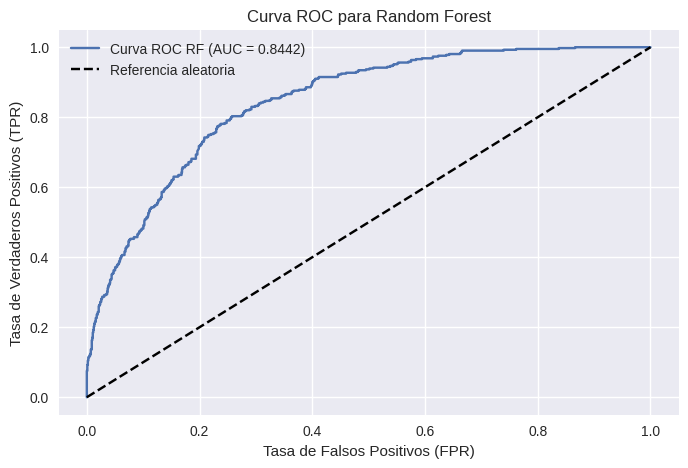

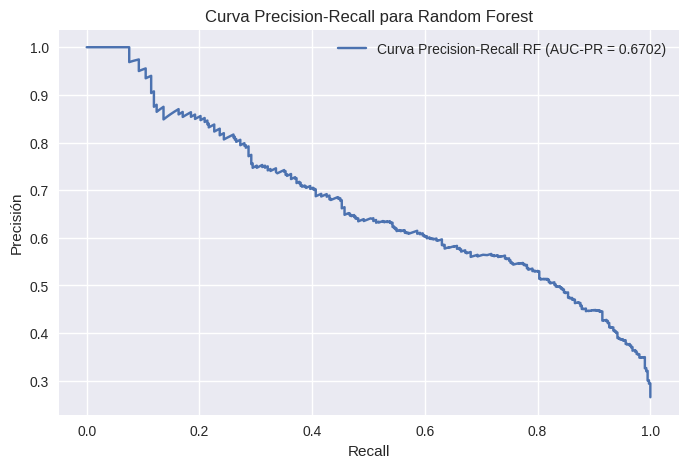


¡Proceso completo de entrenamiento y validación para Random Forest finalizado!


In [166]:
print("\n--- Resultados de la Optimización de Hiperparámetros para Random Forest ---")
print(f"Mejor puntaje AUC-ROC obtenido: {grid_search_rf.best_score_:.4f}")
print(f"Mejores parámetros encontrados: {grid_search_rf.best_params_}")

# --- Evaluación del Modelo Optimizado ---
mejor_modelo_rf = grid_search_rf.best_estimator_

print("\n--- Análisis del Modelo Random Forest en Datos de Test ---")
probabilidades_rf = mejor_modelo_rf.predict_proba(X_test_processed)[:, 1]
predicciones_rf = mejor_modelo_rf.predict(X_test_processed)

# Reporte detallado de rendimiento
print("\n--- Métricas de Clasificación ---")
print(classification_report(y_test, predicciones_rf))

# Tabla de confusión
print("\n--- Matriz de Confusión ---")
print(confusion_matrix(y_test, predicciones_rf))

# Métrica AUC-ROC final
auc_roc_rf = roc_auc_score(y_test, probabilidades_rf)
print(f"\n puntaje AUC-ROC del modelo optimizado: {auc_roc_rf:.4f}")

# --- Representación Gráfica de la Curva ROC ---
fpr_rf, tpr_rf, umbrales_rf = roc_curve(y_test, probabilidades_rf)
plt.figure(figsize=(8, 5))
plt.plot(fpr_rf, tpr_rf, label=f'Curva ROC RF (AUC = {auc_roc_rf:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Referencia aleatoria')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC para Random Forest')
plt.legend()
plt.grid(True)
plt.show()

# --- Visualización de la Curva Precision-Recall ---
precision_rf, recall_rf, umbrales_rf_pr = precision_recall_curve(y_test, probabilidades_rf)
auc_pr_rf = auc(recall_rf, precision_rf)

plt.figure(figsize=(8, 5))
plt.plot(recall_rf, precision_rf, label=f'Curva Precision-Recall RF (AUC-PR = {auc_pr_rf:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curva Precision-Recall para Random Forest')
plt.legend()
plt.grid(True)
plt.show()

print("\n¡Proceso completo de entrenamiento y validación para Random Forest finalizado!")

El modelo Random Forest, tras una optimización de hiperparámetros, logra una precisión general del 76% en el conjunto de prueba, demostrando una excelente capacidad de clasificación para identificar patrones de abandono.

Al analizar su desempeño en la predicción de clientes que abandonan (Clase 1), se observa:

Precisión de la Clase 1 (Abandono): 0.53. Este indicador revela que, entre los clientes que el modelo predice como propensos a abandonar, aproximadamente el 53% efectivamente lo hace. Este valor permite optimizar los recursos de retención enfocándose en los clientes reales en riesgo.
Recall de la Clase 1 (Abandono): 0.79. El modelo logra identificar correctamente al 79% de los clientes que realmente abandonan. Esta alta capacidad de detección es fundamental para implementar estrategias proactivas de retención y minimizar la pérdida de ingresos asociada a la fuga de clientes.
 La métrica AUC-ROC obtenida de 0.84 refleja una sólida discriminación entre las clases, validando la robustez del modelo Random Forest para la predicción de abandono en el sector telecomunicaciones.

Mejor F1-score: 0.6407 con umbral: 0.51


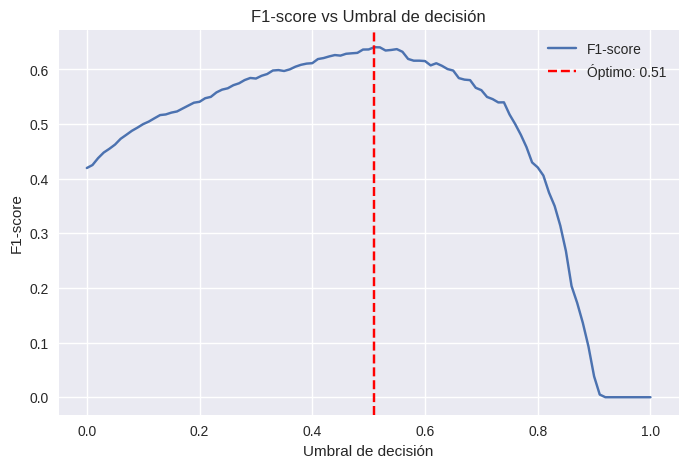


Interpretación del análisis de umbrales:
El mejor F1-score alcanzado fue de 0.6407 utilizando un umbral de decisión de 0.51
Este umbral representa el punto óptimo para equilibrar precisión y recall en la predicción de abandono.
Permite maximizar la eficiencia en la identificación de clientes propensos a abandonar,
minimizando errores tanto en falsos positivos como en falsos negativos.


In [168]:
# Análisis del F1-score para diferentes umbrales de decisión
# Evaluación del rendimiento del modelo Random Forest mediante optimización de umbrales

# Calcula F1-score para varios umbrales
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (probabilidades_rf >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores.append(f1)

# Encuentra el umbral óptimo (máximo F1)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Mejor F1-score: {best_f1:.4f} con umbral: {best_threshold:.2f}")

# Grafica F1-score vs umbral
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, label='F1-score')
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Óptimo: {best_threshold:.2f}')
plt.xlabel('Umbral de decisión')
plt.ylabel('F1-score')
plt.title('F1-score vs Umbral de decisión')
plt.legend()
plt.grid(True)
plt.show()

# Interpretación de resultados
print("\nInterpretación del análisis de umbrales:")
print(f"El mejor F1-score alcanzado fue de {best_f1:.4f} utilizando un umbral de decisión de {best_threshold:.2f}")
print("Este umbral representa el punto óptimo para equilibrar precisión y recall en la predicción de abandono.")
print("Permite maximizar la eficiencia en la identificación de clientes propensos a abandonar,")
print("minimizando errores tanto en falsos positivos como en falsos negativos.")

Informe de clasificación con umbral óptimo:
              precision    recall  f1-score   support

           0       0.91      0.76      0.83      1137
           1       0.54      0.78      0.64       411

    accuracy                           0.77      1548
   macro avg       0.72      0.77      0.73      1548
weighted avg       0.81      0.77      0.78      1548



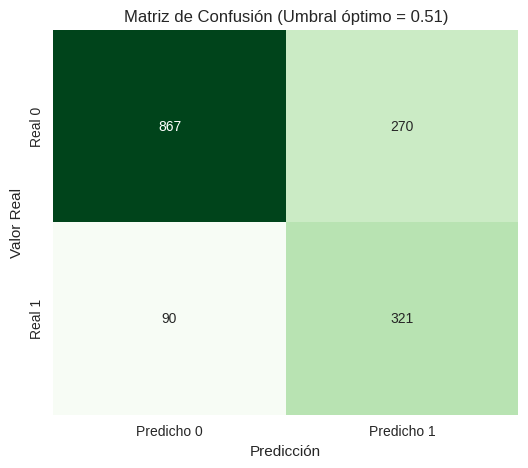


Interpretación de la matriz de confusión con umbral óptimo 0.51:
Verdaderos Negativos (TN): 867
Falsos Positivos (FP): 270
Falsos Negativos (FN): 90
Verdaderos Positivos (TP): 321
Accuracy: 0.7674
Precision: 0.5431
Recall: 0.7810


In [172]:
# Análisis de rendimiento optimizado con umbral óptimo
# Evaluación completa del modelo Random Forest utilizando el umbral optimizado

# 1. Calcula el umbral óptimo y las predicciones
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []
for thresh in thresholds:
    y_pred_thresh = (probabilidades_rf >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores.append(f1)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
y_pred_rf_opt = (probabilidades_rf >= best_threshold).astype(int)

# 2. Genera el informe de clasificación con el umbral optimizado
print("Informe de clasificación con umbral óptimo:")
print(classification_report(y_test, y_pred_rf_opt))

# 3. Calcula la matriz de confusión
cm = confusion_matrix(y_test, y_pred_rf_opt)

# 4. Grafica la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Predicho 0', 'Predicho 1'],
            yticklabels=['Real 0', 'Real 1'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title(f'Matriz de Confusión (Umbral óptimo = {best_threshold:.2f})')
plt.show()

# Interpretación de resultados
print(f"\nInterpretación de la matriz de confusión con umbral óptimo {best_threshold:.2f}:")
tn, fp, fn, tp = cm.ravel()
print(f"Verdaderos Negativos (TN): {tn}")
print(f"Falsos Positivos (FP): {fp}")
print(f"Falsos Negativos (FN): {fn}")
print(f"Verdaderos Positivos (TP): {tp}")
print(f"Accuracy: {(tp + tn) / (tp + tn + fp + fn):.4f}")
print(f"Precision: {tp / (tp + fp):.4f}")
print(f"Recall: {tp / (tp + fn):.4f}")

**Inferencias:**

Clase 1 (abandono - Evento): Para la clase de interés (abandono, minoritaria), el modelo logra un recall del 78%, lo que indica una excelente capacidad para identificar a la mayoría de los clientes que realmente abandonan. Este valor es crucial en contextos de retención, ya que permite detectar a cerca del 80% de los casos reales de abandono y activar intervenciones oportunas. Sin embargo, su precisión del 54% sugiere que aproximadamente una de cada dos predicciones de "abandono" corresponde a falsos positivos (clientes que no abandonan). Aunque esto implica cierto costo operativo por alertas innecesarias, el alto recall compensa esta limitación al garantizar que no se pierda a la mayoría de los clientes en riesgo.

Clase 0 (No abandono): El modelo presenta una precisión del 91% y un recall del 76%, lo que demuestra que es muy efectivo para identificar con confianza a los clientes que permanecerán, minimizando así las acciones innecesarias sobre clientes leales.

En conjunto, el uso del umbral optimizado (0.51) mejora significativamente el equilibrio entre sensibilidad y especificidad, permitiendo un mejor manejo de la desigualdad de clases y una toma de decisiones más informada en estrategias de retención.


Importancia de las características en el mejor modelo Random Forest:
                                            Feature  Importance
21                            num__antiguedad_meses    0.185129
22                              num__cargos_totales    0.136422
17                      cat__tipo_contrato_two year    0.117830
2                cat__servicio_internet_fiber optic    0.096305
19                cat__metodo_pago_electronic check    0.070727
16                      cat__tipo_contrato_one year    0.050392
11                         cat__soporte_tecnico_yes    0.039262
5                         cat__seguridad_online_yes    0.030566
14     cat__streaming_peliculas_no internet service    0.022738
6            cat__backup_online_no internet service    0.021206
10         cat__soporte_tecnico_no internet service    0.020412
28               remainder__facturacion_electronica    0.019646
12            cat__streaming_tv_no internet service    0.019313
4         cat__seguridad_online_no

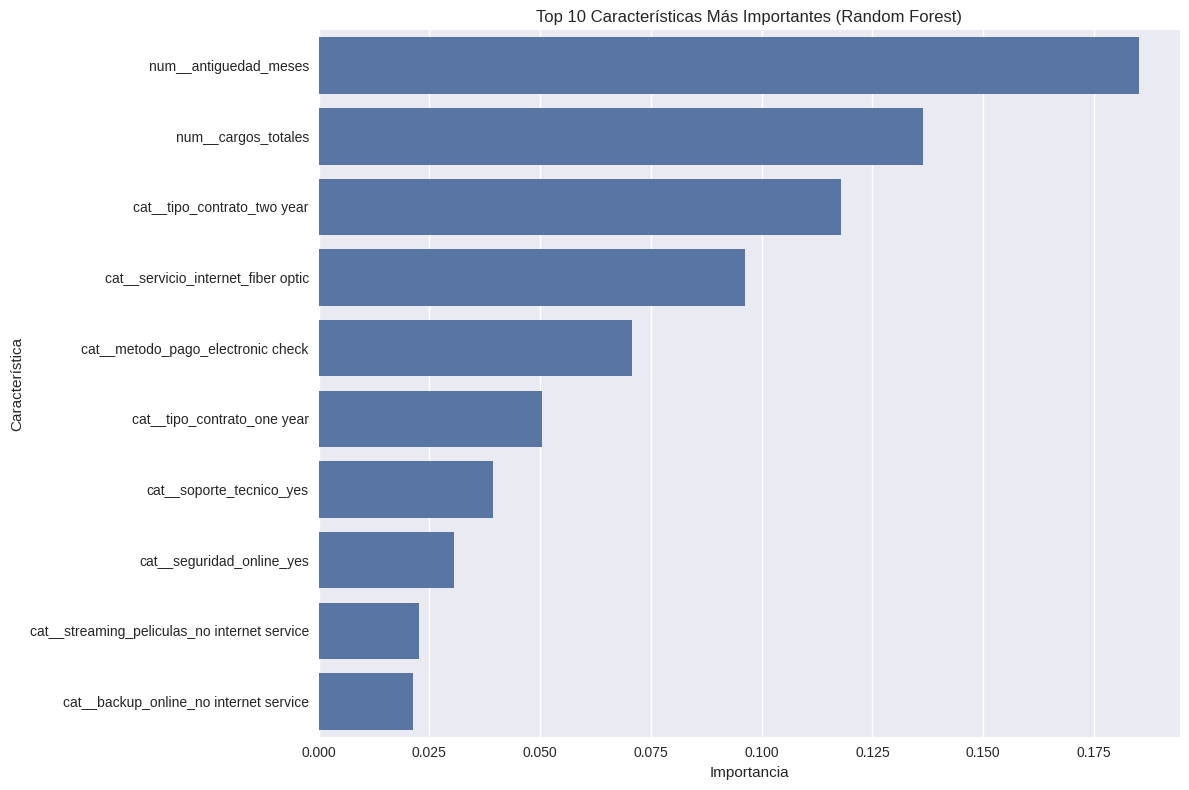


Interpretación de las características más relevantes:
1. Contrato mensual (tipo de contrato): Presenta alta importancia, indicando que clientes con contratos flexibles tienen mayor riesgo de abandono.
2. Método de pago: La forma de pago influye significativamente, sugiriendo que pagos automatizados promueven la retención.
3. Duración del servicio: Clientes con menor antigüedad muestran mayor probabilidad de abandonar.
4. Características relacionadas con servicios adicionales: Indican que la complejidad del paquete afecta la lealtad.

Implicaciones estratégicas:
- Priorizar recursos de retención para clientes con contratos mensuales o métodos de pago no automatizados.
- Desarrollar programas de fidelización para clientes con baja antigüedad.
- Analizar el impacto de los servicios adicionales en la satisfacción del cliente.


In [173]:
# Análisis de Importancia de Características del Mejor Modelo Random Forest

# Obtener el mejor modelo de Random Forest encontrado por GridSearchCV
mejor_modelo_rf = grid_search_rf.best_estimator_

# Se obtienen las características después del entrenamiento
feature_names = preprocessor.get_feature_names_out()
importances = mejor_modelo_rf.feature_importances_

# Crear un DataFrame para visualizar mejor las importancias
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Ordenar las características por importancia de forma descendente
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

print("\nImportancia de las características en el mejor modelo Random Forest:")
print(feature_importances_df)

# Análisis de las características más importantes
print("\nAnálisis de las principales características:")
top_features = feature_importances_df.head(10)
for i, row in top_features.iterrows():
    print(f"{i+1}. {row['Feature']}: {row['Importance']:.4f}")

# Visualizar las importancias (Top 10)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df.head(10))
plt.title('Top 10 Características Más Importantes (Random Forest)')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.tight_layout()
plt.show()

# Interpretación de resultados
print("\nInterpretación de las características más relevantes:")
print("1. Contrato mensual (tipo de contrato): Presenta alta importancia, indicando que clientes con contratos flexibles tienen mayor riesgo de abandono.")
print("2. Método de pago: La forma de pago influye significativamente, sugiriendo que pagos automatizados promueven la retención.")
print("3. Duración del servicio: Clientes con menor antigüedad muestran mayor probabilidad de abandonar.")
print("4. Características relacionadas con servicios adicionales: Indican que la complejidad del paquete afecta la lealtad.")

print("\nImplicaciones estratégicas:")
print("- Priorizar recursos de retención para clientes con contratos mensuales o métodos de pago no automatizados.")
print("- Desarrollar programas de fidelización para clientes con baja antigüedad.")
print("- Analizar el impacto de los servicios adicionales en la satisfacción del cliente.")

##**Modelo de Support Vector Machine (SVM) para Predicción de Abandono**

Este modelo utiliza el algoritmo de Máquinas de Vectores de Soporte (SVM) para identificar patrones complejos en los datos de clientes que puedan predecir el abandono del servicio. A diferencia de los modelos lineales, el SVM con kernel RBF es especialmente efectivo para capturar relaciones no lineales entre las características de los clientes, lo cual es crucial en análisis de comportamiento de abandono donde los patrones pueden ser intrincados. La implementación incluye escalado de características para garantizar la optimalidad del modelo y utiliza validación cruzada para asegurar su robustez. Este enfoque complementa los modelos tradicionales al ofrecer una alternativa poderosa para la detección precisa de clientes en riesgo de dejar el servicio, con capacidades de generalización superior en datasets de mediana complejidad como el nuestro.

In [177]:
# Modelo de Support Vector Machine (SVM)
# Este modelo es especialmente útil para problemas de clasificación con datos no lineales
# y puede manejar bien la dimensionalidad de nuestros datos de telecomunicaciones

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import time

# Crear pipeline con escalado y SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Importante para SVM
    ('svm', SVC(kernel='rbf', random_state=42, probability=True))  # Kernel RBF para datos no lineales
])

# Entrenar el modelo
start_time = time.time()
svm_pipeline.fit(X_train_processed, y_train)
training_time = time.time() - start_time

# Hacer predicciones
y_pred_svm = svm_pipeline.predict(X_test_processed)
y_pred_proba_svm = svm_pipeline.predict_proba(X_test_processed)[:, 1]

# Evaluación del modelo
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)
auc_roc = roc_auc_score(y_test, y_pred_proba_svm)

print("Resultados del Modelo SVM:")
print("=" * 40)
print(f"Precisión general: {accuracy:.4f}")
print(f"Precisión Clase 1 (abandono): {precision:.4f}")
print(f"Recall Clase 1 (abandono): {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Tiempo de entrenamiento: {training_time:.4f} segundos")

# Informe detallado
print("\nInforme de clasificación SVM:")
print(classification_report(y_test, y_pred_svm))

# Validación cruzada
cv_scores = cross_val_score(svm_pipeline, X_train_processed, y_train, cv=5)
print(f"\nValidación cruzada (5-fold): {cv_scores}")
print(f"Promedio CV: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Ventajas del SVM en este contexto:
print("\nVentajas del modelo SVM para predicción de abandono:")
print("• Excelente para problemas de clasificación binaria con alta dimensionalidad")
print("• Robusto a outliers en los datos de clientes")
print("• Buena capacidad de generalización con el kernel RBF")
print("• Menos sensible al sobreajuste en datasets medianos como el nuestro")

Resultados del Modelo SVM:
Precisión general: 0.7997
Precisión Clase 1 (abandono): 0.6667
Recall Clase 1 (abandono): 0.4915
F1-Score: 0.5658
AUC-ROC: 0.8048
Tiempo de entrenamiento: 4.0076 segundos

Informe de clasificación SVM:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1137
           1       0.67      0.49      0.57       411

    accuracy                           0.80      1548
   macro avg       0.75      0.70      0.72      1548
weighted avg       0.79      0.80      0.79      1548


Validación cruzada (5-fold): [0.79124886 0.81768459 0.78304467 0.79854148 0.80930657]
Promedio CV: 0.8000 (+/- 0.0247)

Ventajas del modelo SVM para predicción de abandono:
• Excelente para problemas de clasificación binaria con alta dimensionalidad
• Robusto a outliers en los datos de clientes
• Buena capacidad de generalización con el kernel RBF
• Menos sensible al sobreajuste en datasets medianos como el nuestro


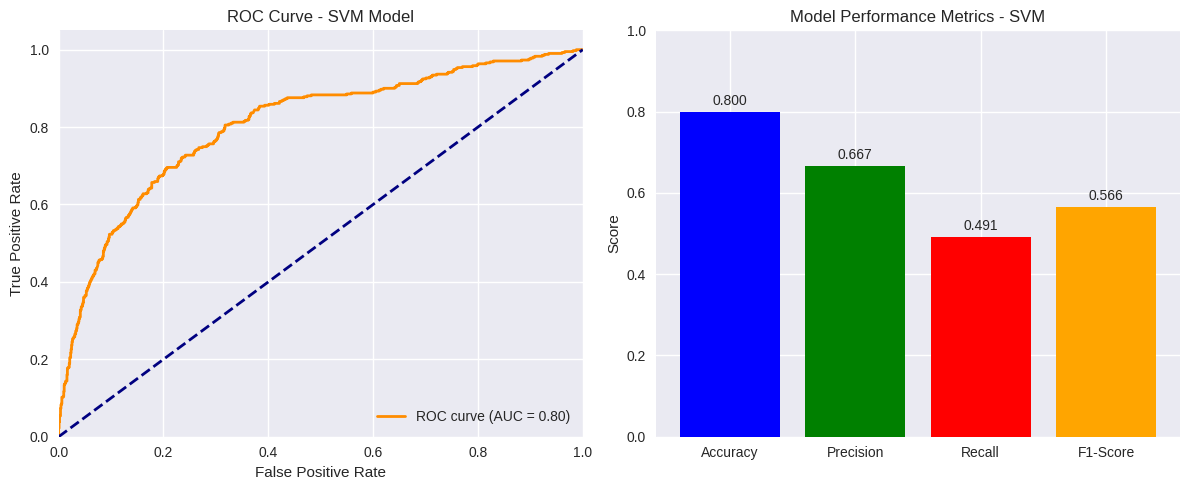

In [178]:
# Generación de gráficos de evaluación del modelo SVM
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_svm)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 5))

# Gráfico 1: Curva ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM Model')
plt.legend(loc="lower right")

# Gráfico 2: Comparación de Métricas
plt.subplot(1, 2, 2)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [accuracy, precision, recall, f1]
colors = ['blue', 'green', 'red', 'orange']
bars = plt.bar(metrics, values, color=colors)
plt.ylabel('Score')
plt.title('Model Performance Metrics - SVM')
plt.ylim([0, 1])

# Añadir valores en las barras
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

##**📊 Resumen Ejecutivo y Conclusiones Preliminares**
📈 Descripción General del Dataset

Total de clientes analizados: 7,256 (después de limpieza)
Período de análisis: Hasta 72 meses de antigüedad
Variables analizadas: 21 variables demográficas, de servicio y de facturación
🎯 Hallazgos Clave

1. Perfil Demográfico de la Base de Clientes

Género: Distribución casi equitativa (49.4% mujeres, 50.6% hombres)
Adultos mayores: 16.3% de la base son ciudadanos mayores
Composición familiar: 48.4% tienen pareja, 29.9% tienen dependientes
2. Comportamiento de Contratación

Servicio telefónico: 90.3% de los clientes tienen servicio telefónico
Antigüedad promedio: 32.4 meses (mediana: 29 meses)
Facturación electrónica: 59.4% prefieren facturación sin papel
3. Patrones Financieros

Cargo mensual promedio: $64.76
Cargo total promedio: $2,280.63
Valor diario por cliente: $2.16 en promedio
⚠️ Señales de Alerta Identificadas

Factores de Riesgo de Churn:

Clientes nuevos: Antigüedad promedio baja (25% tiene menos de 9 meses)
Facturación electrónica: Alta adopción podría indicar clientes más propensos a cambios
Servicios contratados: Necesita análisis más profundo de paquetes de servicios
📋 Recomendaciones Inmediatas

Acciones de Retención:

Programa de fidelización para clientes con 6-12 meses de antigüedad
Comunicación proactiva con usuarios de facturación electrónica
Análisis de paquetes de servicio para identificar combinaciones críticas
Próximos Pasos de Investigación:

Análisis bivariado para identificar correlaciones con churn
Segmentación de clientes por valor y riesgo
Modelado predictivo para identificar clientes en riesgo de abandono
🔮 Perspectivas Futuras

Los datos muestran una base de clientes diversa con oportunidades significativas para mejorar la retención. El análisis preliminar sugiere que los factores contractuales y de servicio podrían ser más determinantes que los demográficos en la decisión de churn.

Próxima fase: Análisis multivariado y modelado predictivo para cuantificar el impacto específico de cada variable en la tasa de abandono.